In [216]:
# Import dependencies
import importlib
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np
from SCL import Model
import SCL
importlib.reload(SCL)
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import data_loader_gen as dlg
importlib.reload(dlg)
from sklearn.metrics import recall_score
from langdetect import detect
from sklearn.linear_model import LogisticRegression

## Bootstrapping

One way to evaluate model performance is to bootstrap the unseen data in the test set and aggregate model accuracies across many samples.

In [111]:
BATCH_SIZE = 100

In [121]:
# Define a function to return macro recall from bootstrapped predictions
def get_recall(preds, targs, sample_size):
    recalls = []
    i = 0
    j = sample_size
    convert_dict = {0:[1,0,0], 1:[0,1,0], 2:[0,0,1]}
    for targs_sample, preds_sample in zip(targs,preds):
        macro_recall = recall_score(targs_sample, preds_sample, average='macro')
        recalls.append(macro_recall)
        i += sample_size
        j += sample_size
    return np.mean(recalls), np.std(recalls)

In [116]:
# run bootstrapping on each model
data_loader_0_test = dlg.data_loader_0_test
temp_0_model = Model(data_loader_0_test, None, filepath = 'temp_0_models', hidden_size = 900)
temp_0_accuracy = temp_0_model.run_bootstrap(10000, dlg.temp_0_test, dlg.temp_0_targs_test)
temp_0_preds = temp_0_model.preds
temp_0_targs = temp_0_model.targs

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:26<00:00, 116.10it/s]


In [122]:
# print results
avg_recall, recall_std = get_recall(temp_0_preds, temp_0_targs, len(temp_0_test))
print('Average Recall :' + str(avg_recall))
print('Recall std: ' + str(recall_std))

Average Recall :0.5392038776871199
Recall std: 0.04912522568524986


In [126]:
data_loader_7_test = dlg.data_loader_7_test
temp_7_model = Model(data_loader_7_test, None, filepath = 'temp_7_models', hidden_size = 900)
temp_7_accuracy = temp_7_model.run_bootstrap(10000, dlg.temp_7_test, dlg.temp_7_targs_test)
temp_7_preds = temp_7_model.preds
temp_7_targs = temp_7_model.targs
avg_recall, recall_std = get_recall(temp_7_preds, temp_7_targs, len(temp_7_test))
print('Average Recall :' + str(avg_recall))
print('Recall std: ' + str(recall_std))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:39<00:00, 100.45it/s]


Average Recall :0.49402686172671173
Recall std: 0.04920187475071098


In [130]:
data_loader_14_test = dlg.data_loader_14_test
temp_14_model = Model(data_loader_14_test, None, filepath = 'temp_14_models', hidden_size = 200)
temp_14_accuracy = temp_14_model.run_bootstrap(10000, dlg.temp_14_test, dlg.temp_14_targs_test)
temp_14_preds = temp_14_model.preds
temp_14_targs = temp_14_model.targs
avg_recall, recall_std = get_recall(temp_14_preds, temp_14_targs, len(temp_14_test))
print('Average Recall :' + str(avg_recall))
print('Recall std: ' + str(recall_std))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:51<00:00, 193.35it/s]


Average Recall :0.4854613418482476
Recall std: 0.04979659790431582


In [131]:
data_loader_all_test = dlg.data_loader_all_test
temp_all_model = Model(data_loader_all_test, None, filepath = 'temp_all_models', hidden_size = 800)
temp_all_accuracy = temp_all_model.run_bootstrap(10000, temp_all_test, temp_all_targs_test)
temp_all_preds = temp_all_model.preds
temp_all_targs = temp_all_model.targs
avg_recall, recall_std = get_recall(temp_all_preds, temp_all_targs, len(temp_all_test))
print('Average Recall :' + str(avg_recall))
print('Recall std: ' + str(recall_std))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:45<00:00, 34.99it/s]


Average Recall :0.49638638345139274
Recall std: 0.050273126219133324


In [132]:
data = {'temp_0':temp_0_accuracy, 'temp_7':temp_7_accuracy, 'temp_14':temp_14_accuracy, 'temp_all':temp_all_accuracy}
bootstrap_df = pd.DataFrame(data)

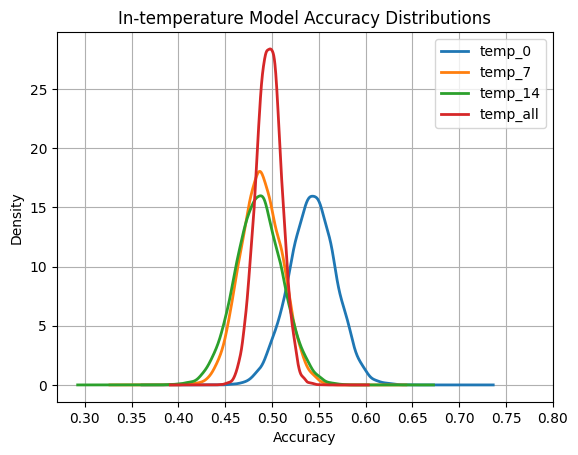

In [133]:
# display bootstrap accuracy distributions as a density plot
for column in bootstrap_df.columns:
    bootstrap_df[column].plot(kind='density', linestyle='-', linewidth=2, label=column)
plt.title('In-temperature Model Accuracy Distributions')
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.xticks(ticks=[i/100 for i in range(30, 81, 5)])
plt.legend()
plt.grid()
plt.show()

In [136]:
# display accuracies and standard deviations 
for column in bootstrap_df.columns:
    print(f'Std {column}: ' + str(np.std(bootstrap_df[column])))
    print(f'Avg acc {column}: '.format(column) + str(np.mean(bootstrap_df[column])))

Std temp_0: 0.02497912428408971
Avg acc temp_0: 0.54314
Std temp_7: 0.022073338646430452
Avg acc temp_7: 0.48841100000000004
Std temp_14: 0.025178844888864536
Avg acc temp_14: 0.48590975
Std temp_all: 0.013369828335258674
Avg acc temp_all: 0.49639028571428573


## 1.1 Ablation Tests

The CLS embeddings generated by BERT have 768 features. These features are not interpretable by humans because they have been abstracted through BERT's networks. However, the combined embeddings our model uses includes 29 normalized structural, syntactical, and lexical features that are easily understood by humans. We will remove each type of feature by substituting 0 for those column values.

In [56]:
# Create lexical ablation embeddings
def get_lexical_ablations(data):
    return [
    torch.tensor(np.concatenate((embedding[0, 0:746], np.zeros(22), embedding[0, 768:])), dtype=torch.float32).unsqueeze(0) for embedding in data
]

In [57]:
# Create syntactic ablation embeddings
def get_syntactic_ablations(data):
    return [
    torch.tensor(np.concatenate((embedding[0, 0:768], np.zeros(3), embedding[0, 771:])), dtype=torch.float32).unsqueeze(0) for embedding in data
]

In [58]:
# Create structural ablation embeddings
def get_structural_ablations(data):
    return [torch.tensor(np.concatenate((embedding[0, 0:793], np.zeros(4))), dtype=torch.float32).unsqueeze(0) for embedding in data]

In [61]:
# get ablation accuracies 
lex_0_train_dataset = SCL.WordEmbeddingDataset(get_lexical_ablations(dlg.temp_0_train), dlg.temp_0_targs_train)
lex_0_val_dataset = SCL.WordEmbeddingDataset(get_lexical_ablations(dlg.temp_0_val), dlg.temp_0_targs_val)
lex_0_train_dataloader = DataLoader(lex_0_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
lex_0_val_dataloader = DataLoader(lex_0_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
temp_0_lex_model = Model(lex_0_train_dataloader, lex_0_val_dataloader)
temp_0_lex_model.gen_model(900, 0.15)
temp_0_lex_accuracy = temp_0_lex_model.run_bootstrap(20000, get_lexical_ablations(dlg.temp_0_test), dlg.temp_0_targs_test)

 10%|████████▏                                                                         | 1/10 [01:58<17:47, 118.60s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5296442687747036
Best Validation Accuracy: 0.5491726618705035


 20%|████████████████▍                                                                 | 2/10 [03:34<14:03, 105.45s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5217391304347826
Best Validation Accuracy: 0.550891838253535


 30%|████████████████████████▌                                                         | 3/10 [05:32<12:56, 110.86s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5246137261947539
Best Validation Accuracy: 0.5560704539816423


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [03:02<00:00, 109.32it/s]


In [62]:
temp_0_lex_accuracy = temp_0_lex_model.run_bootstrap(20000, get_lexical_ablations(dlg.temp_0_test), dlg.temp_0_targs_test)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [03:03<00:00, 109.23it/s]


In [63]:
lex_7_train_dataset = SCL.WordEmbeddingDataset(get_lexical_ablations(dlg.temp_7_train), dlg.temp_7_targs_train)
lex_7_val_dataset = SCL.WordEmbeddingDataset(get_lexical_ablations(dlg.temp_7_val), dlg.temp_7_targs_val)
lex_7_train_dataloader = DataLoader(lex_7_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
lex_7_val_dataloader = DataLoader(lex_7_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
temp_7_lex_model = Model(lex_7_train_dataloader, lex_7_val_dataloader)
temp_7_lex_model.gen_model(900, 0.05)
temp_7_lex_accuracy = temp_7_lex_model.run_bootstrap(20000, get_lexical_ablations(dlg.temp_7_test), dlg.temp_7_targs_test)

 10%|████████▎                                                                          | 1/10 [01:33<14:04, 93.85s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5225
Best Validation Accuracy: 0.5228571428571428


 30%|████████████████████████▉                                                          | 3/10 [04:48<11:25, 97.89s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5217857142857143
Best Validation Accuracy: 0.5231428571428571


 40%|█████████████████████████████████▏                                                 | 4/10 [06:25<09:47, 97.88s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5164285714285715
Best Validation Accuracy: 0.5294285714285715


 70%|██████████████████████████████████████████████████████████                         | 7/10 [11:10<04:48, 96.05s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5164285714285715
Best Validation Accuracy: 0.5354285714285714


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:01<00:00, 82.80it/s]


In [64]:
lex_14_train_dataset = SCL.WordEmbeddingDataset(get_lexical_ablations(dlg.temp_14_train), dlg.temp_14_targs_train)
lex_14_val_dataset = SCL.WordEmbeddingDataset(get_lexical_ablations(dlg.temp_14_val), dlg.temp_14_targs_val)
lex_14_train_dataloader = DataLoader(lex_14_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
lex_14_val_dataloader = DataLoader(lex_14_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
temp_14_lex_model = Model(lex_14_train_dataloader, lex_14_val_dataloader)
temp_14_lex_model.gen_model(200, 0.15)
temp_14_lex_accuracy = temp_14_lex_model.run_bootstrap(20000, get_lexical_ablations(dlg.temp_14_test), dlg.temp_14_targs_test)

 10%|████████▎                                                                          | 1/10 [00:51<07:39, 51.06s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5210674157303371
Best Validation Accuracy: 0.5248640939332164


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:39<00:00, 201.52it/s]


In [65]:
lex_all_train_dataset = SCL.WordEmbeddingDataset(get_lexical_ablations(dlg.temp_all_train), dlg.temp_all_targs_train)
lex_all_val_dataset = SCL.WordEmbeddingDataset(get_lexical_ablations(dlg.temp_all_val), dlg.temp_all_targs_val)
lex_all_train_dataloader = DataLoader(lex_all_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
lex_all_val_dataloader = DataLoader(lex_all_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
temp_all_lex_model = Model(lex_all_train_dataloader, lex_all_val_dataloader)
temp_all_lex_model.gen_model(800, 0.20)
temp_all_lex_accuracy = temp_all_lex_model.run_bootstrap(20000, get_lexical_ablations(dlg.temp_all_test), dlg.temp_all_targs_test)

 10%|████████▏                                                                         | 1/10 [03:54<35:14, 234.93s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4872494366030127
Best Validation Accuracy: 0.5232469431883782


 20%|████████████████▍                                                                 | 2/10 [09:36<39:39, 297.46s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5020756731111374
Best Validation Accuracy: 0.5314115593724361


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [45:26<05:05, 305.14s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4946032499110426
Best Validation Accuracy: 0.5325459366041991


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [09:33<00:00, 34.87it/s]


In [66]:
data = {'temp_0':temp_0_lex_accuracy, 'temp_7':temp_7_lex_accuracy, 
        'temp_14':temp_14_lex_accuracy, 'temp_all':temp_all_lex_accuracy}
lexical_ablation_df = pd.DataFrame(data)

In [67]:
for column in lexical_ablation_df.columns:
    print(f'Std {column}: ' + str(np.std(lexical_ablation_df[column])))
    print(f'Avg acc {column}: ' + str(np.mean(lexical_ablation_df[column])))

Std temp_0: 0.02485311036369493
Avg acc temp_0: 0.5353804999999999
Std temp_7: 0.022352916582629674
Avg acc temp_7: 0.5022955
Std temp_14: 0.025105735773611075
Avg acc temp_14: 0.49453112499999996
Std temp_all: 0.01337067547057892
Avg acc temp_all: 0.47449239285714284


## Get structural ablations

In [68]:
struc_0_train_dataset = SCL.WordEmbeddingDataset(get_structural_ablations(dlg.temp_0_train), dlg.temp_0_targs_train)
struc_0_val_dataset = SCL.WordEmbeddingDataset(get_structural_ablations(dlg.temp_0_val), dlg.temp_0_targs_val)
struc_0_train_dataloader = DataLoader(struc_0_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
struc_0_val_dataloader = DataLoader(struc_0_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
temp_0_struc_model = Model(struc_0_train_dataloader, struc_0_val_dataloader)
temp_0_struc_model.gen_model(900, 0.15)
temp_0_struc_accuracy = temp_0_struc_model.run_bootstrap(20000, get_structural_ablations(dlg.temp_0_test), dlg.temp_0_targs_test)

 10%|████████▏                                                                         | 1/10 [01:47<16:09, 107.77s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5357527847646425
Best Validation Accuracy: 0.53508310592905


 20%|████████████████▍                                                                 | 2/10 [03:46<15:14, 114.35s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5292849443047072
Best Validation Accuracy: 0.550879020921194


 60%|█████████████████████████████████████████████████▏                                | 6/10 [11:32<07:54, 118.70s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5278476464247215
Best Validation Accuracy: 0.5551980484577854


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:20<00:00, 99.59it/s]


In [69]:
struc_7_train_dataset = SCL.WordEmbeddingDataset(get_structural_ablations(dlg.temp_7_train), dlg.temp_7_targs_train)
struc_7_val_dataset = SCL.WordEmbeddingDataset(get_structural_ablations(dlg.temp_7_val), dlg.temp_7_targs_val)
struc_7_train_dataloader = DataLoader(struc_7_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
struc_7_val_dataloader = DataLoader(struc_7_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
temp_7_struc_model = Model(struc_7_train_dataloader, struc_7_val_dataloader)
temp_7_struc_model.gen_model(900, 0.15)
temp_7_struc_accuracy = temp_7_struc_model.run_bootstrap(20000, get_structural_ablations(dlg.temp_7_test), dlg.temp_7_targs_test)

 10%|████████▏                                                                         | 1/10 [01:50<16:34, 110.49s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5142857142857142
Best Validation Accuracy: 0.5185714285714286


 20%|████████████████▍                                                                 | 2/10 [03:33<14:09, 106.23s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5278571428571428
Best Validation Accuracy: 0.5237142857142857


 30%|████████████████████████▌                                                         | 3/10 [05:38<13:23, 114.82s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5175
Best Validation Accuracy: 0.5265714285714285


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [14:05<06:08, 122.82s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5117857142857143
Best Validation Accuracy: 0.5382857142857143


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:31<00:00, 94.35it/s]


In [70]:
struc_14_train_dataset = SCL.WordEmbeddingDataset(get_structural_ablations(dlg.temp_14_train), dlg.temp_14_targs_train)
struc_14_val_dataset = SCL.WordEmbeddingDataset(get_structural_ablations(dlg.temp_14_val), dlg.temp_14_targs_val)
struc_14_train_dataloader = DataLoader(struc_14_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
struc_14_val_dataloader = DataLoader(struc_14_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
temp_14_struc_model = Model(struc_14_train_dataloader, struc_14_val_dataloader)
temp_14_struc_model.gen_model(900, 0.15)
temp_14_struc_accuracy = temp_14_struc_model.run_bootstrap(20000, get_structural_ablations(dlg.temp_14_test), dlg.temp_14_targs_test)

 10%|████████▏                                                                         | 1/10 [02:15<20:15, 135.10s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.514747191011236
Best Validation Accuracy: 0.5209275589057981


 60%|█████████████████████████████████████████████████▏                                | 6/10 [10:32<06:55, 103.77s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5108848314606742
Best Validation Accuracy: 0.5240277185164115


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [14:07<03:31, 105.76s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5129915730337079
Best Validation Accuracy: 0.5262689833910144


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [03:01<00:00, 110.22it/s]


In [71]:
struc_all_train_dataset = SCL.WordEmbeddingDataset(get_structural_ablations(dlg.temp_all_train), dlg.temp_all_targs_train)
struc_all_val_dataset = SCL.WordEmbeddingDataset(get_structural_ablations(dlg.temp_all_val), dlg.temp_all_targs_val)
struc_all_train_dataloader = DataLoader(struc_all_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
struc_all_val_dataloader = DataLoader(struc_all_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
temp_all_struc_model = Model(struc_all_train_dataloader, struc_all_val_dataloader)
temp_all_struc_model.gen_model(900, 0.15)
temp_all_struc_accuracy = temp_all_struc_model.run_bootstrap(20000, get_structural_ablations(dlg.temp_all_test), dlg.temp_all_targs_test)

 10%|████████▏                                                                         | 1/10 [04:12<37:49, 252.22s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4852330684379077
Best Validation Accuracy: 0.521918895089919


 30%|████████████████████████▌                                                         | 3/10 [16:18<39:55, 342.24s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4966196180761476
Best Validation Accuracy: 0.5220169237987768


 40%|████████████████████████████████▊                                                 | 4/10 [21:53<33:55, 339.32s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4966196180761476
Best Validation Accuracy: 0.5304621623593173


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:47<00:00, 30.89it/s]


In [72]:
data = {'temp_0':temp_0_struc_accuracy, 'temp_7':temp_7_struc_accuracy, 
        'temp_14':temp_14_struc_accuracy, 'temp_all':temp_all_struc_accuracy}
structural_ablation_df = pd.DataFrame(data)

In [73]:
for column in structural_ablation_df.columns:
    print(f'Std {column}: '+ str(np.std(structural_ablation_df[column])))
    print(f'Avg acc {column}: ' + str(np.mean(structural_ablation_df[column])))

Std temp_0: 0.02477647066144612
Avg acc temp_0: 0.53535125
Std temp_7: 0.02236202576489886
Avg acc temp_7: 0.5002713
Std temp_14: 0.02504041969714914
Avg acc temp_14: 0.475206625
Std temp_all: 0.01338025445018837
Avg acc temp_all: 0.5038855357142857


## Get syntactical ablation accuracies

In [74]:
synt_0_train_dataset = SCL.WordEmbeddingDataset(get_syntactic_ablations(dlg.temp_0_train), dlg.temp_0_targs_train)
synt_0_val_dataset = SCL.WordEmbeddingDataset(get_syntactic_ablations(dlg.temp_0_val), dlg.temp_0_targs_val)
synt_0_train_dataloader = DataLoader(synt_0_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
synt_0_val_dataloader = DataLoader(synt_0_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
temp_0_synt_model = Model(synt_0_train_dataloader, synt_0_val_dataloader)
temp_0_synt_model.gen_model(900, 0.15)
temp_0_synt_accuracy = temp_0_synt_model.run_bootstrap(20000, get_syntactic_ablations(dlg.temp_0_test), dlg.temp_0_targs_test)

 10%|████████▏                                                                         | 1/10 [01:42<15:25, 102.84s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5353934602946461
Best Validation Accuracy: 0.5402522120234846


 20%|████████████████▍                                                                 | 2/10 [03:33<14:19, 107.42s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5339561624146605
Best Validation Accuracy: 0.5468647151244521


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [15:53<01:45, 105.93s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5353934602946461
Best Validation Accuracy: 0.5486058050111635


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [17:30<00:00, 105.07s/it]


**MODEL UPDATED**
Average Training Accuracy: 0.5170679123248293
Best Validation Accuracy: 0.5503162986851897


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:58<00:00, 111.77it/s]


In [75]:
synt_7_train_dataset = SCL.WordEmbeddingDataset(get_syntactic_ablations(dlg.temp_7_train), dlg.temp_7_targs_train)
synt_7_val_dataset = SCL.WordEmbeddingDataset(get_syntactic_ablations(dlg.temp_7_val), dlg.temp_7_targs_val)
synt_7_train_dataloader = DataLoader(synt_7_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
synt_7_val_dataloader = DataLoader(synt_7_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
temp_7_synt_model = Model(synt_7_train_dataloader, synt_7_val_dataloader)
temp_7_synt_model.gen_model(900, 0.15)
temp_7_synt_accuracy = temp_7_synt_model.run_bootstrap(20000, get_syntactic_ablations(dlg.temp_7_test), dlg.temp_7_targs_test)

 10%|████████▎                                                                          | 1/10 [01:38<14:49, 98.83s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5246428571428572
Best Validation Accuracy: 0.5182857142857143


 20%|████████████████▍                                                                 | 2/10 [03:33<14:26, 108.28s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5185714285714286
Best Validation Accuracy: 0.5351428571428571


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:30<00:00, 95.14it/s]


In [76]:
synt_14_train_dataset = SCL.WordEmbeddingDataset(get_syntactic_ablations(dlg.temp_14_train), dlg.temp_14_targs_train)
synt_14_val_dataset = SCL.WordEmbeddingDataset(get_syntactic_ablations(dlg.temp_14_val), dlg.temp_14_targs_val)
synt_14_train_dataloader = DataLoader(synt_14_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
synt_14_val_dataloader = DataLoader(synt_14_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
temp_14_synt_model = Model(synt_14_train_dataloader, synt_14_val_dataloader)
temp_14_synt_model.gen_model(900, 0.15)
temp_14_synt_accuracy = temp_14_synt_model.run_bootstrap(20000, get_syntactic_ablations(dlg.temp_14_test), dlg.temp_14_targs_test)

 10%|████████▏                                                                         | 1/10 [01:47<16:04, 107.20s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5059691011235955
Best Validation Accuracy: 0.5206450797262916


 60%|█████████████████████████████████████████████████▏                                | 6/10 [10:19<06:44, 101.18s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5084269662921348
Best Validation Accuracy: 0.5231771203716873


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [03:10<00:00, 104.79it/s]


In [77]:
synt_all_train_dataset = SCL.WordEmbeddingDataset(get_syntactic_ablations(dlg.temp_all_train), dlg.temp_all_targs_train)
synt_all_val_dataset = SCL.WordEmbeddingDataset(get_syntactic_ablations(dlg.temp_all_val), dlg.temp_all_targs_val)
synt_all_train_dataloader = DataLoader(synt_all_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
synt_all_val_dataloader = DataLoader(synt_all_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
temp_all_synt_model = Model(synt_all_train_dataloader, synt_all_val_dataloader)
temp_all_synt_model.gen_model(900, 0.15)
temp_all_synt_accuracy = temp_all_synt_model.run_bootstrap(20000, get_syntactic_ablations(dlg.temp_all_test), dlg.temp_all_targs_test)

 10%|████████▏                                                                         | 1/10 [05:05<45:47, 305.31s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4927054916380026
Best Validation Accuracy: 0.5224891456957877


 20%|████████████████▍                                                                 | 2/10 [09:55<39:31, 296.39s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4997034752698375
Best Validation Accuracy: 0.5224916673346007


 40%|████████████████████████████████▊                                                 | 4/10 [20:46<32:01, 320.25s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4966196180761476
Best Validation Accuracy: 0.5264777028590881


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [55:19<00:00, 331.93s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49828015656505753
Best Validation Accuracy: 0.5277069117219281



100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:56<00:00, 30.48it/s]


In [78]:
data = {'temp_0':temp_0_synt_accuracy, 'temp_7':temp_7_synt_accuracy, 
        'temp_14':temp_14_synt_accuracy, 'temp_all':temp_all_synt_accuracy}
syntactic_ablation_df = pd.DataFrame(data)

In [79]:
for column in syntactic_ablation_df.columns:
    print('Std {}: '.format(column) + str(np.std(syntactic_ablation_df[column])))
    print('Avg acc {}: '.format(column) + str(np.mean(syntactic_ablation_df[column])))

Std temp_0: 0.024940898635574468
Avg acc temp_0: 0.5353255000000001
Std temp_7: 0.022116991856715052
Avg acc temp_7: 0.4763511
Std temp_14: 0.02531873740403291
Avg acc temp_14: 0.502888875
Std temp_all: 0.013463494463298349
Avg acc temp_all: 0.5025935714285714


It appears removing the stylometric feature vectors did little to change model accuracy. For processing improvements, future iterations of this model may omit the stylometric feature vectors.

## 1.2 Hyperparameter Sensitivity Analysis

The hyperparameters available to be tuned in our model are hidden_size_1, hidden_size_2, dropout_percent, learning_rate, step_size, supconloss_temperature, and gamma. As the project is based around contrastive loss, we would like to investigate the sensitivity of hidden_size_2 (number of features being fed into the contrastive loss function) and supconloss_temp

In [83]:
# Analyze FAM output sensitivity
hidden_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

data_loaders = [(dlg.data_loader_0_train, dlg.data_loader_0_val),(dlg.data_loader_7_train, dlg.data_loader_7_val),
                (dlg.data_loader_14_train, dlg.data_loader_14_val), (dlg.data_loader_all_train, dlg.data_loader_all_val)]
test_data = [(dlg.temp_0_test, dlg.temp_0_targs_test), (dlg.temp_7_test, dlg.temp_7_targs_test),
             (dlg.temp_14_test, dlg.temp_14_targs_test), (dlg.temp_all_test, dlg.temp_all_targs_test)]
DEFAULT_TEMP = 0.07
temp_0_accs = []
temp_7_accs = []
temp_14_accs = []
temp_all_accs = []
temp_0_stds = []
temp_7_stds = []
temp_14_stds = []
temp_all_stds = []
for hidden_size in hidden_sizes:
    for i, loaders in enumerate(data_loaders):
        model = SCL.Model(loaders[0], loaders[1])
        model.gen_model(hidden_size, DEFAULT_TEMP)
        accuracies = model.run_bootstrap(20000, test_data[i][0], test_data[i][1])
        avg_acc = np.mean(accuracies)
        std = np.std(accuracies)
        if i ==0: 
            temp_0_accs.append(avg_acc)
            temp_0_stds.append(std)
        if i ==1: 
            temp_7_accs.append(avg_acc)
            temp_7_stds.append(std)
        if i ==2: 
            temp_14_accs.append(avg_acc)
            temp_14_stds.append(std)
        if i ==3: 
            temp_all_accs.append(avg_acc)
            temp_all_stds.append(std)

 10%|████████▎                                                                          | 1/10 [00:37<05:38, 37.63s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5292849443047072
Best Validation Accuracy: 0.5293173736872571


 20%|████████████████▌                                                                  | 2/10 [01:08<04:30, 33.77s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5375494071146245
Best Validation Accuracy: 0.5330670635905068


 30%|████████████████████████▉                                                          | 3/10 [01:47<04:12, 36.03s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5289256198347108
Best Validation Accuracy: 0.544570412635409


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:10<03:16, 39.37s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5199425080848006
Best Validation Accuracy: 0.5454386835359298


 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:30<01:59, 39.90s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5382680560546174
Best Validation Accuracy: 0.5569263210121558


 10%|████████▎                                                                          | 1/10 [00:32<04:50, 32.23s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5207142857142857
Best Validation Accuracy: 0.5265714285714286


 40%|█████████████████████████████████▏                                                 | 4/10 [02:25<03:44, 37.39s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5385714285714286
Best Validation Accuracy: 0.5268571428571429


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:04<03:09, 37.86s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5367857142857143
Best Validation Accuracy: 0.5348571428571429


 10%|████████▎                                                                          | 1/10 [00:47<07:09, 47.70s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5196629213483146
Best Validation Accuracy: 0.5181205455206309


 30%|████████████████████████▉                                                          | 3/10 [02:01<04:38, 39.85s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5143960674157303
Best Validation Accuracy: 0.526265032633259


 10%|████████▏                                                                         | 1/10 [02:02<18:21, 122.34s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4961451785078876
Best Validation Accuracy: 0.5237228574850794


 20%|████████████████▍                                                                 | 2/10 [03:58<15:50, 118.78s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4983987664571225
Best Validation Accuracy: 0.5244825912360442


 40%|████████████████████████████████▊                                                 | 4/10 [07:13<10:24, 104.09s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49804293678092754
Best Validation Accuracy: 0.5306516455044132


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [18:40<00:00, 112.01s/it]


**MODEL UPDATED**
Average Training Accuracy: 0.4983987664571225
Best Validation Accuracy: 0.5357733190800701


 10%|████████▎                                                                          | 1/10 [00:45<06:50, 45.61s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5271289974847287
Best Validation Accuracy: 0.5462809063094352


 20%|████████████████▌                                                                  | 2/10 [01:33<06:16, 47.10s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5314408911246856
Best Validation Accuracy: 0.5480141404118085


 30%|████████████████████████▉                                                          | 3/10 [02:25<05:45, 49.32s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5411426518145885
Best Validation Accuracy: 0.5483014967336476


 40%|█████████████████████████████████▏                                                 | 4/10 [03:14<04:54, 49.02s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5267696730147323
Best Validation Accuracy: 0.5531906888282478


 10%|████████▎                                                                          | 1/10 [00:36<05:29, 36.57s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5171428571428571
Best Validation Accuracy: 0.5114285714285715


 20%|████████████████▌                                                                  | 2/10 [01:22<05:38, 42.29s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5132142857142857
Best Validation Accuracy: 0.5191428571428572


 30%|████████████████████████▉                                                          | 3/10 [02:06<05:00, 42.96s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5
Best Validation Accuracy: 0.5251428571428571


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:17<02:54, 43.73s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5292857142857142
Best Validation Accuracy: 0.5268571428571428


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [05:51<01:32, 46.29s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5192857142857142
Best Validation Accuracy: 0.5285714285714287


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:17<00:00, 43.75s/it]


**MODEL UPDATED**
Average Training Accuracy: 0.5139285714285714
Best Validation Accuracy: 0.5294285714285714


 10%|████████▎                                                                          | 1/10 [00:40<06:03, 40.37s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5150983146067416
Best Validation Accuracy: 0.5029480554370329


 20%|████████████████▌                                                                  | 2/10 [01:19<05:15, 39.43s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5087780898876404
Best Validation Accuracy: 0.5077225461843582


 30%|████████████████████████▉                                                          | 3/10 [02:15<05:29, 47.05s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.519311797752809
Best Validation Accuracy: 0.5153044453926263


 40%|█████████████████████████████████▏                                                 | 4/10 [03:01<04:40, 46.71s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5080758426966292
Best Validation Accuracy: 0.5189608716951911


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:46<03:50, 46.16s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5126404494382022
Best Validation Accuracy: 0.521773416141216


 10%|████████▏                                                                         | 1/10 [02:05<18:50, 125.63s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4878424860633377
Best Validation Accuracy: 0.5219207863190287


 20%|████████████████▍                                                                 | 2/10 [04:01<16:00, 120.04s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4927054916380026
Best Validation Accuracy: 0.5316953788266995


 50%|█████████████████████████████████████████                                         | 5/10 [10:52<11:05, 133.03s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49673822796821254
Best Validation Accuracy: 0.5333065259111898


 10%|████████▎                                                                          | 1/10 [00:44<06:44, 44.92s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5278476464247215
Best Validation Accuracy: 0.5359410402712312


 20%|████████████████▌                                                                  | 2/10 [01:49<07:33, 56.64s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5425799496945742
Best Validation Accuracy: 0.5448474323989085


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:21<03:28, 52.21s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5267696730147323
Best Validation Accuracy: 0.5500293558256842


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:05<00:00, 54.53s/it]


**MODEL UPDATED**
Average Training Accuracy: 0.5314408911246856
Best Validation Accuracy: 0.5529103613660796


 10%|████████▎                                                                          | 1/10 [00:59<08:57, 59.71s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5267857142857143
Best Validation Accuracy: 0.5359999999999999


 10%|████████▎                                                                          | 1/10 [00:57<08:37, 57.55s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5182584269662921
Best Validation Accuracy: 0.5122204838888098


 20%|████████████████▌                                                                  | 2/10 [01:48<07:08, 53.53s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5172050561797753
Best Validation Accuracy: 0.5139102229807677


 30%|████████████████████████▉                                                          | 3/10 [02:45<06:28, 55.44s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5136938202247191
Best Validation Accuracy: 0.5212076676306516


 70%|██████████████████████████████████████████████████████████                         | 7/10 [06:23<02:43, 54.50s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5263342696629213
Best Validation Accuracy: 0.521487776355505


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [07:27<01:55, 57.58s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5214185393258427
Best Validation Accuracy: 0.5214885665070561


 10%|████████▏                                                                         | 1/10 [02:37<23:40, 157.87s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4961451785078876
Best Validation Accuracy: 0.5227724698281413


 30%|████████████████████████▌                                                         | 3/10 [07:52<18:29, 158.55s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4989918159174475
Best Validation Accuracy: 0.5229650599924891


 40%|████████████████████████████████▊                                                 | 4/10 [10:33<15:57, 159.61s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49567073893962754
Best Validation Accuracy: 0.531508102115565


 50%|█████████████████████████████████████████                                         | 5/10 [13:30<13:48, 165.72s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5036176017079824
Best Validation Accuracy: 0.5323581195418903


 10%|████████▎                                                                          | 1/10 [01:11<10:45, 71.77s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5411426518145885
Best Validation Accuracy: 0.5468663689737865


 50%|█████████████████████████████████████████▌                                         | 5/10 [05:28<05:38, 67.73s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5400646784045994
Best Validation Accuracy: 0.5500124038700076


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [06:29<04:21, 65.27s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5361121092346389
Best Validation Accuracy: 0.5500260481270156


 10%|████████▎                                                                          | 1/10 [00:56<08:26, 56.24s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5175
Best Validation Accuracy: 0.516


 20%|████████████████▌                                                                  | 2/10 [02:02<08:16, 62.01s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5271428571428571
Best Validation Accuracy: 0.528


 30%|████████████████████████▉                                                          | 3/10 [03:00<07:00, 60.09s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5296428571428572
Best Validation Accuracy: 0.5337142857142857


 50%|█████████████████████████████████████████▌                                         | 5/10 [05:11<05:15, 63.16s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5289285714285714
Best Validation Accuracy: 0.5351428571428571


 10%|████████▎                                                                          | 1/10 [00:58<08:49, 58.86s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5143960674157303
Best Validation Accuracy: 0.5105327201757297


 20%|████████████████▌                                                                  | 2/10 [01:46<06:59, 52.45s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5133426966292135
Best Validation Accuracy: 0.5175579576162709


 50%|█████████████████████████████████████████▌                                         | 5/10 [04:34<04:32, 54.47s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5129915730337079
Best Validation Accuracy: 0.518122125823733


 10%|████████▏                                                                         | 1/10 [03:24<30:36, 204.09s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4950776894793026
Best Validation Accuracy: 0.5289429200037105


 20%|████████████████▍                                                                 | 2/10 [06:30<25:47, 193.48s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4994662554857075
Best Validation Accuracy: 0.5306522308848521


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:17<09:13, 184.45s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49590795872375754
Best Validation Accuracy: 0.5368202044508725


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:18<06:06, 183.36s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4936543707745226
Best Validation Accuracy: 0.5382417333024733


 10%|████████▎                                                                          | 1/10 [00:59<08:52, 59.19s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5407833273445921
Best Validation Accuracy: 0.5388183246506244


 40%|█████████████████████████████████▏                                                 | 4/10 [04:25<06:54, 69.15s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.539705353934603
Best Validation Accuracy: 0.554921028694286


 10%|████████▎                                                                          | 1/10 [01:05<09:52, 65.83s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5239285714285714
Best Validation Accuracy: 0.5117142857142858


 20%|████████████████▌                                                                  | 2/10 [02:19<09:25, 70.64s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5128571428571429
Best Validation Accuracy: 0.5371428571428571


 10%|████████▎                                                                          | 1/10 [01:18<11:42, 78.08s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5133426966292135
Best Validation Accuracy: 0.513912593435421


 30%|████████████████████████▉                                                          | 3/10 [03:34<08:12, 70.38s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5316011235955056
Best Validation Accuracy: 0.5231707991592788


 10%|████████▏                                                                         | 1/10 [03:02<27:24, 182.76s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49140078282528765
Best Validation Accuracy: 0.5268558586225188


 20%|████████████████▍                                                                 | 2/10 [05:57<23:43, 177.96s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5030245522476574
Best Validation Accuracy: 0.5298919117534486


 30%|████████████████████████▌                                                         | 3/10 [09:59<24:10, 207.15s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4927054916380026
Best Validation Accuracy: 0.5335915161263305


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [27:12<07:06, 213.35s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5025501126793974
Best Validation Accuracy: 0.5336864828452011


 10%|████████▎                                                                          | 1/10 [01:17<11:40, 77.86s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5285662953647143
Best Validation Accuracy: 0.5514595220375423


 70%|██████████████████████████████████████████████████████████                         | 7/10 [09:03<03:53, 77.77s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5328781890046712
Best Validation Accuracy: 0.5523377160340693


 10%|████████▎                                                                          | 1/10 [01:20<12:06, 80.71s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5207142857142857
Best Validation Accuracy: 0.5302857142857144


 20%|████████████████▌                                                                  | 2/10 [02:35<10:19, 77.48s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5103571428571428
Best Validation Accuracy: 0.538


 10%|████████▎                                                                          | 1/10 [01:15<11:18, 75.38s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5133426966292135
Best Validation Accuracy: 0.5167176314417105


 20%|████████████████▌                                                                  | 2/10 [02:26<09:44, 73.09s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5052668539325843
Best Validation Accuracy: 0.5206517960144755


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [10:03<02:38, 79.38s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5217696629213483
Best Validation Accuracy: 0.5212096430095292


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:21<00:00, 74.11s/it]


**MODEL UPDATED**
Average Training Accuracy: 0.5133426966292135
Best Validation Accuracy: 0.5223411400306579


 10%|████████▏                                                                         | 1/10 [04:12<37:51, 252.37s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49626378839995255
Best Validation Accuracy: 0.5332131802458417


 50%|█████████████████████████████████████████                                         | 5/10 [18:34<18:25, 221.09s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49697544775234254
Best Validation Accuracy: 0.5337815396226008


 10%|████████▎                                                                          | 1/10 [01:14<11:09, 74.36s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5285662953647143
Best Validation Accuracy: 0.5414020507731745


 20%|████████████████▌                                                                  | 2/10 [02:38<10:40, 80.08s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5235357527847646
Best Validation Accuracy: 0.5445617299264036


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [10:26<02:41, 80.73s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5264103485447359
Best Validation Accuracy: 0.546592243446622


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [12:06<01:26, 86.82s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5321595400646784
Best Validation Accuracy: 0.5569383114198297


 10%|████████▎                                                                          | 1/10 [01:04<09:42, 64.72s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5103571428571428
Best Validation Accuracy: 0.5245714285714286


 20%|████████████████▌                                                                  | 2/10 [02:22<09:40, 72.60s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5160714285714286
Best Validation Accuracy: 0.5268571428571428


 30%|████████████████████████▉                                                          | 3/10 [03:54<09:29, 81.32s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5328571428571428
Best Validation Accuracy: 0.5271428571428571


 50%|█████████████████████████████████████████▌                                         | 5/10 [06:27<06:37, 79.52s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5214285714285715
Best Validation Accuracy: 0.5365714285714286


 10%|████████▎                                                                          | 1/10 [01:15<11:18, 75.36s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5196629213483146
Best Validation Accuracy: 0.4995827999810364


 20%|████████████████▌                                                                  | 2/10 [02:41<10:55, 81.95s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5105337078651685
Best Validation Accuracy: 0.5068838003129


 30%|████████████████████████▉                                                          | 3/10 [03:47<08:42, 74.59s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5154494382022472
Best Validation Accuracy: 0.5181150144597734


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [07:42<05:12, 78.05s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5066713483146067
Best Validation Accuracy: 0.5192465114809021


 70%|██████████████████████████████████████████████████████████                         | 7/10 [08:51<03:45, 75.22s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5158005617977528
Best Validation Accuracy: 0.5237385230487208


 10%|████████▏                                                                         | 1/10 [04:12<37:54, 252.74s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49057051358083265
Best Validation Accuracy: 0.5171744316631378


 20%|████████████████▍                                                                 | 2/10 [07:53<31:11, 233.90s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4979243268888625
Best Validation Accuracy: 0.5294172582761536


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [27:43<12:10, 243.56s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4981615466729925
Best Validation Accuracy: 0.532359830653942


 10%|████████▎                                                                          | 1/10 [01:34<14:08, 94.23s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5407833273445921
Best Validation Accuracy: 0.5437058628958902


 30%|████████████████████████▌                                                         | 3/10 [05:01<12:02, 103.17s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5436579231045634
Best Validation Accuracy: 0.5554812701562888


 10%|████████▎                                                                          | 1/10 [01:37<14:40, 97.81s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5225
Best Validation Accuracy: 0.5377142857142857


 10%|████████▎                                                                          | 1/10 [01:35<14:18, 95.37s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5122893258426966
Best Validation Accuracy: 0.5153155075143413


 20%|████████████████▌                                                                  | 2/10 [03:13<12:56, 97.04s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.516502808988764
Best Validation Accuracy: 0.5175567723889442


 30%|████████████████████████▉                                                          | 3/10 [04:31<10:18, 88.29s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5210674157303371
Best Validation Accuracy: 0.5183939379573002


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [11:47<02:56, 88.14s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.507373595505618
Best Validation Accuracy: 0.5184026296243619


 10%|████████▏                                                                         | 1/10 [04:05<36:50, 245.57s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49733127742853755
Best Validation Accuracy: 0.5241977811379616


 30%|████████████████████████▌                                                         | 3/10 [14:08<34:12, 293.21s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5042106511683074
Best Validation Accuracy: 0.5286572993788663


 40%|████████████████████████████████▊                                                 | 4/10 [18:09<27:16, 272.82s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4983987664571225
Best Validation Accuracy: 0.5294175284517408


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [32:38<14:16, 285.50s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49733127742853755
Best Validation Accuracy: 0.5309354649586766


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [37:03<09:17, 278.92s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4953149092634326
Best Validation Accuracy: 0.5352999264221818


 10%|████████▏                                                                         | 1/10 [01:48<16:15, 108.41s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5278476464247215
Best Validation Accuracy: 0.5454291739022575


 30%|████████████████████████▉                                                          | 3/10 [04:32<10:13, 87.71s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5357527847646425
Best Validation Accuracy: 0.5517431571983793


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [12:54<03:21, 100.64s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5332375134746676
Best Validation Accuracy: 0.5529136690647483


 10%|████████▏                                                                         | 1/10 [01:41<15:17, 101.91s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5310714285714285
Best Validation Accuracy: 0.5191428571428571


 20%|████████████████▍                                                                 | 2/10 [03:31<14:09, 106.16s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5246428571428572
Best Validation Accuracy: 0.5405714285714286


 10%|████████▎                                                                          | 1/10 [01:28<13:18, 88.69s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5175561797752809
Best Validation Accuracy: 0.5158784904944768


 20%|████████████████▌                                                                  | 2/10 [03:10<12:53, 96.66s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5150983146067416
Best Validation Accuracy: 0.5186827383492154


 40%|████████████████████████████████▊                                                 | 4/10 [06:45<10:29, 104.84s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5203651685393258
Best Validation Accuracy: 0.5192425607231467


 50%|█████████████████████████████████████████                                         | 5/10 [08:20<08:26, 101.29s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.526685393258427
Best Validation Accuracy: 0.5192449311777999


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [13:21<03:22, 101.36s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5221207865168539
Best Validation Accuracy: 0.5228970116468338


 10%|████████▏                                                                         | 1/10 [06:26<57:57, 386.36s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49140078282528765
Best Validation Accuracy: 0.5217301324130552


 20%|████████████████▍                                                                 | 2/10 [12:09<48:07, 360.89s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5011267939746175
Best Validation Accuracy: 0.5297036894277591


 60%|█████████████████████████████████████████████████▏                                | 6/10 [31:15<19:49, 297.47s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49934764559364253
Best Validation Accuracy: 0.5306509250361809


 10%|████████▏                                                                         | 1/10 [01:44<15:38, 104.32s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5343154868846568
Best Validation Accuracy: 0.52645001240387


 20%|████████████████▌                                                                  | 2/10 [03:15<12:54, 96.86s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.525691699604743
Best Validation Accuracy: 0.5324886297858266


 30%|████████████████████████▌                                                         | 3/10 [05:07<12:04, 103.50s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5289256198347108
Best Validation Accuracy: 0.5517472918217151


 50%|█████████████████████████████████████████                                         | 5/10 [08:50<09:20, 112.01s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.541501976284585
Best Validation Accuracy: 0.5583523526006781


 10%|████████▎                                                                          | 1/10 [01:30<13:34, 90.52s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5146428571428572
Best Validation Accuracy: 0.5248571428571429


 20%|████████████████▌                                                                  | 2/10 [03:14<13:05, 98.19s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5128571428571429
Best Validation Accuracy: 0.5257142857142857


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [14:19<01:40, 100.71s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5314285714285715
Best Validation Accuracy: 0.5288571428571429


 10%|████████▏                                                                         | 1/10 [01:58<17:44, 118.28s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5052668539325843
Best Validation Accuracy: 0.5172766636640908


 40%|████████████████████████████████▊                                                 | 4/10 [07:29<11:16, 112.76s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5245786516853933
Best Validation Accuracy: 0.517560328070924


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [12:53<05:31, 110.56s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5273876404494382
Best Validation Accuracy: 0.5251449928096209


 10%|████████▏                                                                         | 1/10 [05:19<47:57, 319.67s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4953149092634326
Best Validation Accuracy: 0.5240075775246332


 20%|████████████████▍                                                                 | 2/10 [10:54<43:48, 328.55s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49626378839995255
Best Validation Accuracy: 0.5248651598673978


 30%|████████████████████████▌                                                         | 3/10 [18:19<44:33, 381.92s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5033803819238525
Best Validation Accuracy: 0.5344474323863079


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [11:20<00:00, 29.40it/s]


In [85]:
data = {'temp_0':temp_0_accs, 'temp_7':temp_7_accs, 'temp_14':temp_14_accs, 
        'temp_all':temp_all_accs, 'temp_0_stds':temp_0_stds, 'temp_7_stds':temp_7_stds,
       'temp_14_stds':temp_14_stds,'temp_all_stds':temp_all_stds}
hidden_size_df = pd.DataFrame(data)
hidden_size_df.index = hidden_sizes

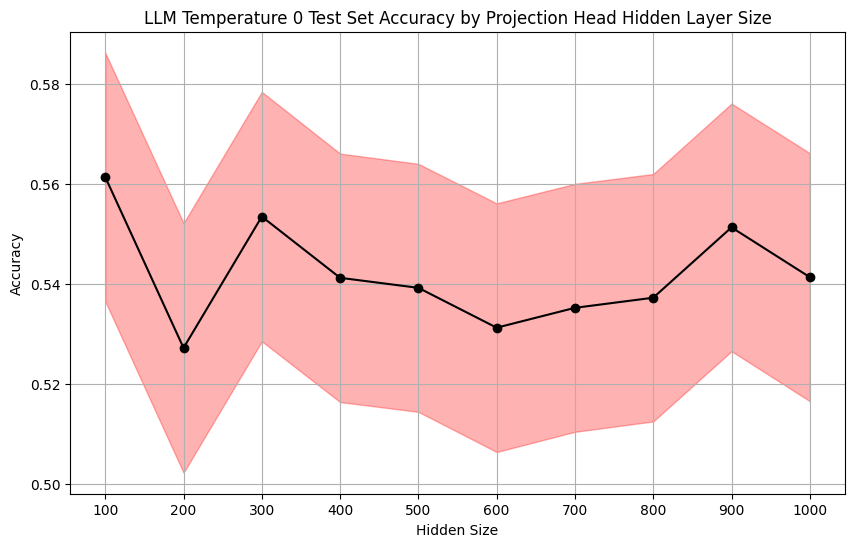

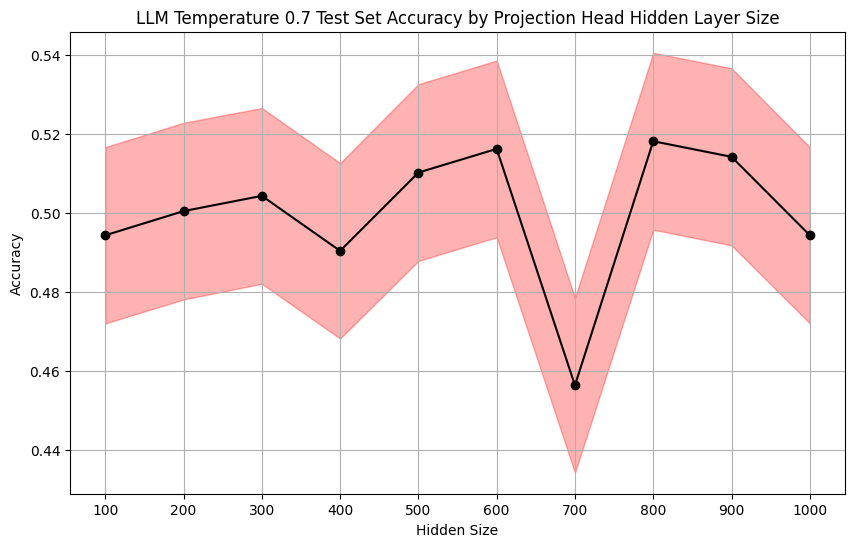

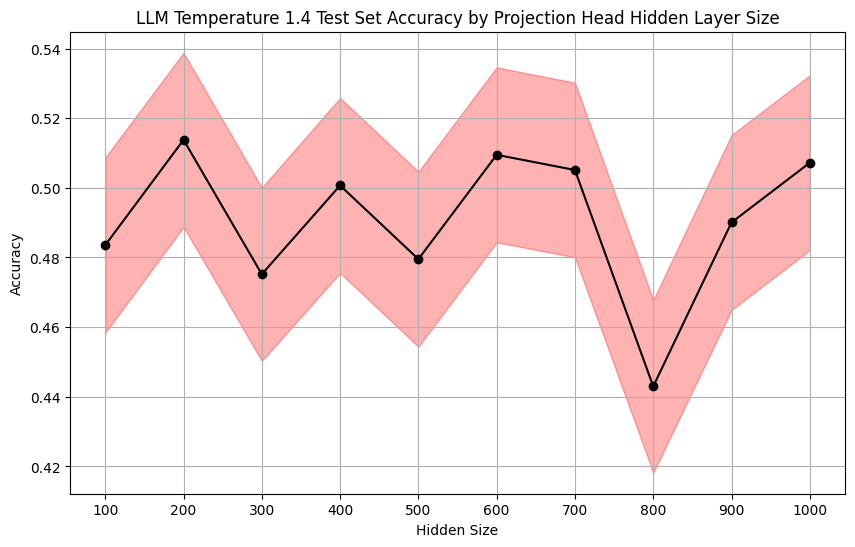

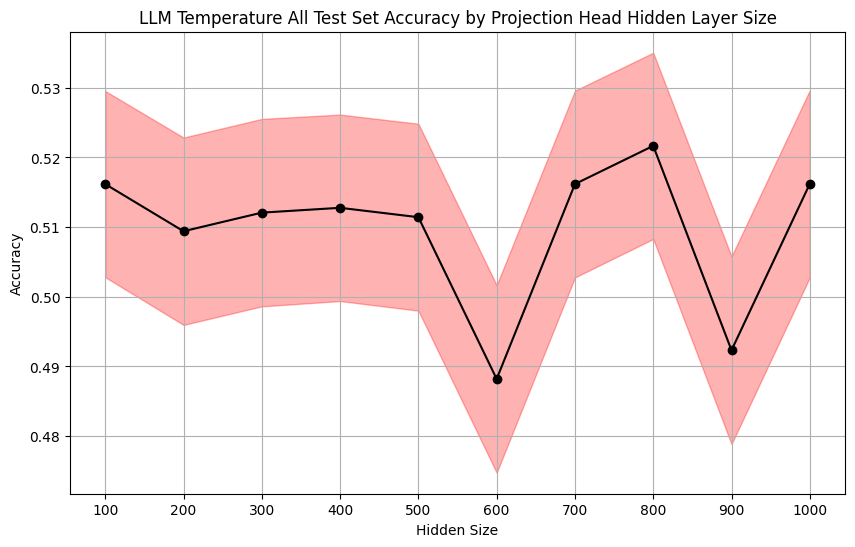

In [99]:
def gen_hidden_size_plot(temp):
    plt.figure(figsize=(10, 6))
    plt.plot(hidden_size_df.index, hidden_size_df[f'temp_{temp}'], label=f'Temperature {temp}', color='black', marker='o')
    plt.fill_between(
        hidden_size_df.index,
        hidden_size_df[f'temp_{temp}'] - hidden_size_df[f'temp_{temp}_stds'],  
        hidden_size_df[f'temp_{temp}'] + hidden_size_df[f'temp_{temp}_stds'],  
        color='red', alpha=0.3  
    )
    
    temp_dict = {'0':'0', '7':'0.7', '14':'1.4', 'all':'All'}
    plt.title(f'LLM Temperature {temp_dict[temp]} Test Set Accuracy by Projection Head Hidden Layer Size')
    plt.xlabel('Hidden Size')
    plt.ylabel('Accuracy')
    plt.xticks(hidden_size_df.index) 
    plt.grid()
    plt.show()
for temp in ['0','7','14','all']:
    gen_hidden_size_plot(temp)

In [239]:
# Analyze FAM output sensitivity
temps = [0.01, 0.05, 0.10, 0.15, 0.2, 0.25, 0.30]

data_loaders = [(dlg.data_loader_0_train, dlg.data_loader_0_val),(dlg.data_loader_7_train, dlg.data_loader_7_val),
                (dlg.data_loader_14_train, dlg.data_loader_14_val), (dlg.data_loader_all_train, dlg.data_loader_all_val)]
test_data = [(dlg.temp_0_test, dlg.temp_0_targs_test), (dlg.temp_7_test, dlg.temp_7_targs_test),
             (dlg.temp_14_test, dlg.temp_14_targs_test), (dlg.temp_all_test, dlg.temp_all_targs_test)]
DEFAULT_SIZE  = 300
temp_0_accs = []
temp_7_accs = []
temp_14_accs = []
temp_all_accs = []
temp_0_stds = []
temp_7_stds = []
temp_14_stds = []
temp_all_stds = []
for temp in temps:
    for i, loaders in enumerate(data_loaders):
        model = SCL.Model(loaders[0], loaders[1])
        model.gen_model(DEFAULT_SIZE, temp)
        accuracies = model.run_bootstrap(20000,test_data[i][0], test_data[i][1])
        avg_acc = np.mean(accuracies)
        std = np.std(accuracies)
        if i ==0: 
            temp_0_accs.append(avg_acc)
            temp_0_stds.append(std)
        if i ==1: 
            temp_7_accs.append(avg_acc)
            temp_7_stds.append(std)
        if i ==2: 
            temp_14_accs.append(avg_acc)
            temp_14_stds.append(std)
        if i ==3: 
            temp_all_accs.append(avg_acc)
            temp_all_stds.append(std)

 10%|████████▎                                                                          | 1/10 [00:58<08:44, 58.28s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5368307581746317
Best Validation Accuracy: 0.5482948813363102


 20%|████████████████▌                                                                  | 2/10 [02:11<08:56, 67.06s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5314408911246856
Best Validation Accuracy: 0.5511787811130405


 40%|█████████████████████████████████▏                                                 | 4/10 [04:02<06:03, 60.51s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5350341358246496
Best Validation Accuracy: 0.5520396096915572


 10%|████████▎                                                                          | 1/10 [01:16<11:29, 76.61s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5153571428571428
Best Validation Accuracy: 0.5331428571428571


 40%|█████████████████████████████████▏                                                 | 4/10 [04:47<07:06, 71.01s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5217857142857143
Best Validation Accuracy: 0.5342857142857144


 10%|████████▎                                                                          | 1/10 [00:50<07:30, 50.04s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5161516853932584
Best Validation Accuracy: 0.515879280646028


 30%|████████████████████████▉                                                          | 3/10 [02:48<06:36, 56.62s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5249297752808989
Best Validation Accuracy: 0.516711310229302


 50%|█████████████████████████████████████████▌                                         | 5/10 [04:57<05:16, 63.20s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5259831460674157
Best Validation Accuracy: 0.5192476967082287


 70%|██████████████████████████████████████████████████████████                         | 7/10 [07:38<03:34, 71.66s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5221207865168539
Best Validation Accuracy: 0.5240190268493496


 10%|████████▏                                                                         | 1/10 [02:55<26:23, 175.90s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.48985885422844266
Best Validation Accuracy: 0.5309350146660314


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:23<09:35, 191.68s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49472185980310757
Best Validation Accuracy: 0.5329302613768687


 10%|████████▎                                                                          | 1/10 [01:21<12:10, 81.19s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5400646784045994
Best Validation Accuracy: 0.5497386918051765


 40%|█████████████████████████████████▏                                                 | 4/10 [04:44<06:56, 69.35s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5375494071146245
Best Validation Accuracy: 0.5563549160671464


 10%|████████▎                                                                          | 1/10 [00:52<07:53, 52.63s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5182142857142857
Best Validation Accuracy: 0.5254285714285715


 20%|████████████████▌                                                                  | 2/10 [01:38<06:29, 48.72s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.525
Best Validation Accuracy: 0.5279999999999999


 40%|█████████████████████████████████▏                                                 | 4/10 [03:24<05:09, 51.65s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5267857142857143
Best Validation Accuracy: 0.5351428571428571


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [08:00<00:54, 54.86s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5210714285714285
Best Validation Accuracy: 0.5371428571428571


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:07<00:00, 54.78s/it]


**MODEL UPDATED**
Average Training Accuracy: 0.5342857142857143
Best Validation Accuracy: 0.5408571428571428


 10%|████████▎                                                                          | 1/10 [00:47<07:11, 47.93s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.519311797752809
Best Validation Accuracy: 0.5189644273771709


 20%|████████████████▌                                                                  | 2/10 [01:56<08:02, 60.36s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5224719101123596
Best Validation Accuracy: 0.5240210022282275


 10%|████████▏                                                                         | 1/10 [03:05<27:46, 185.16s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4936543707745226
Best Validation Accuracy: 0.5223016438383306


 20%|████████████████▍                                                                 | 2/10 [06:28<26:05, 195.68s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49828015656505753
Best Validation Accuracy: 0.5275202203912323


 60%|█████████████████████████████████████████████████▏                                | 6/10 [20:28<14:39, 219.77s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5070572885778674
Best Validation Accuracy: 0.5330230666910426


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [34:10<00:00, 205.05s/it]


**MODEL UPDATED**
Average Training Accuracy: 0.5004151346222275
Best Validation Accuracy: 0.5348242823010675


 10%|████████▎                                                                          | 1/10 [00:59<08:57, 59.74s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5271289974847287
Best Validation Accuracy: 0.5368039361614156


 20%|████████████████▌                                                                  | 2/10 [01:57<07:48, 58.55s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5350341358246496
Best Validation Accuracy: 0.549159431075829


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [08:57<00:55, 55.37s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5228171038447719
Best Validation Accuracy: 0.5537753245679319


 10%|████████▎                                                                          | 1/10 [00:57<08:38, 57.61s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.52
Best Validation Accuracy: 0.5194285714285715


 30%|████████████████████████▉                                                          | 3/10 [03:12<07:45, 66.51s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5282142857142857
Best Validation Accuracy: 0.5334285714285715


 50%|█████████████████████████████████████████▌                                         | 5/10 [05:22<05:30, 66.03s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5292857142857142
Best Validation Accuracy: 0.5337142857142856


 10%|████████▎                                                                          | 1/10 [01:06<09:58, 66.47s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5084269662921348
Best Validation Accuracy: 0.5214968630983423


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [08:55<02:06, 63.48s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5280898876404494
Best Validation Accuracy: 0.5240206071524518


 10%|████████▏                                                                         | 1/10 [02:32<22:50, 152.22s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4981615466729925
Best Validation Accuracy: 0.5164179400192185


 20%|████████████████▍                                                                 | 2/10 [05:03<20:13, 151.72s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4938915905586526
Best Validation Accuracy: 0.5268547779201703


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:43<10:05, 201.96s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5005337445142924
Best Validation Accuracy: 0.5311242276355405


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [29:32<03:42, 222.20s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5031431621397224
Best Validation Accuracy: 0.5348249127107707


 10%|████████▎                                                                          | 1/10 [00:54<08:12, 54.68s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5425799496945742
Best Validation Accuracy: 0.5428392458447036


 20%|████████████████▌                                                                  | 2/10 [02:00<08:09, 61.15s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5307222421846928
Best Validation Accuracy: 0.5442677582072273


 30%|████████████████████████▉                                                          | 3/10 [03:14<07:50, 67.26s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5375494071146245
Best Validation Accuracy: 0.5551939138344496


 10%|████████▎                                                                          | 1/10 [00:49<07:23, 49.33s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5267857142857143
Best Validation Accuracy: 0.5145714285714286


 20%|████████████████▌                                                                  | 2/10 [01:36<06:26, 48.34s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5253571428571429
Best Validation Accuracy: 0.5305714285714286


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [07:39<00:52, 52.43s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5217857142857143
Best Validation Accuracy: 0.534


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:41<00:00, 52.17s/it]


**MODEL UPDATED**
Average Training Accuracy: 0.5296428571428572
Best Validation Accuracy: 0.5362857142857143


 10%|████████▎                                                                          | 1/10 [00:50<07:37, 50.81s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5291432584269663
Best Validation Accuracy: 0.5186851088038686


 20%|████████████████▌                                                                  | 2/10 [02:01<08:19, 62.42s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5200140449438202
Best Validation Accuracy: 0.5226236192101645


 40%|█████████████████████████████████▏                                                 | 4/10 [03:58<05:55, 59.18s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5150983146067416
Best Validation Accuracy: 0.5257087659413076


 10%|████████▏                                                                         | 1/10 [03:16<29:30, 196.71s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4948404696951726
Best Validation Accuracy: 0.5278982860961339


 20%|████████████████▍                                                                 | 2/10 [06:36<26:26, 198.35s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4985173763491875
Best Validation Accuracy: 0.5316963244412543


 10%|████████▎                                                                          | 1/10 [00:49<07:29, 49.91s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5274883219547252
Best Validation Accuracy: 0.5439936326800628


 30%|████████████████████████▉                                                          | 3/10 [02:32<05:59, 51.35s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5292849443047072
Best Validation Accuracy: 0.5460014057719342


 40%|█████████████████████████████████▏                                                 | 4/10 [03:28<05:18, 53.02s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.525691699604743
Best Validation Accuracy: 0.5506123377160341


 10%|████████▎                                                                          | 1/10 [01:24<12:43, 84.86s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5439285714285714
Best Validation Accuracy: 0.5354285714285714


 10%|████████▎                                                                          | 1/10 [00:52<07:56, 52.93s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.511938202247191
Best Validation Accuracy: 0.5141903317056211


 30%|████████████████████████▉                                                          | 3/10 [02:32<05:59, 51.41s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5161516853932584
Best Validation Accuracy: 0.5161506977038195


 50%|█████████████████████████████████████████▌                                         | 5/10 [04:28<04:35, 55.10s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5256320224719101
Best Validation Accuracy: 0.5170005056969927


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:26<03:43, 55.90s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5182584269662921
Best Validation Accuracy: 0.5178483383112881


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [07:51<00:51, 51.35s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5235252808988764
Best Validation Accuracy: 0.5203716872896221


 10%|████████▏                                                                         | 1/10 [02:15<20:19, 135.45s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49697544775234254
Best Validation Accuracy: 0.5095852444503683


 30%|████████████████████████▌                                                         | 3/10 [07:41<18:17, 156.79s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49697544775234254
Best Validation Accuracy: 0.527139497959724


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [17:44<07:41, 153.75s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5020756731111374
Best Validation Accuracy: 0.5314113342261135


 10%|████████▎                                                                          | 1/10 [00:51<07:43, 51.55s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5310815666546892
Best Validation Accuracy: 0.5477218225419664


 30%|████████████████████████▉                                                          | 3/10 [02:45<06:29, 55.71s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.539705353934603
Best Validation Accuracy: 0.5485797568841478


 70%|██████████████████████████████████████████████████████████                         | 7/10 [06:23<02:43, 54.62s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5174272367948257
Best Validation Accuracy: 0.5563540891424792


 10%|████████▎                                                                          | 1/10 [00:54<08:09, 54.37s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5246428571428572
Best Validation Accuracy: 0.522


 20%|████████████████▌                                                                  | 2/10 [01:54<07:41, 57.67s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5303571428571429
Best Validation Accuracy: 0.5231428571428571


 30%|████████████████████████▉                                                          | 3/10 [03:01<07:14, 62.09s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.53
Best Validation Accuracy: 0.5240000000000001


 40%|█████████████████████████████████▏                                                 | 4/10 [03:51<05:42, 57.11s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5207142857142857
Best Validation Accuracy: 0.5305714285714286


 10%|████████▎                                                                          | 1/10 [00:45<06:45, 45.01s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.511938202247191
Best Validation Accuracy: 0.5223371892729026


 50%|█████████████████████████████████████████▌                                         | 5/10 [04:21<04:31, 54.35s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5154494382022472
Best Validation Accuracy: 0.5231802809778916


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:23<03:46, 56.68s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5256320224719101
Best Validation Accuracy: 0.5271152357022076


 10%|████████▏                                                                         | 1/10 [02:51<25:42, 171.34s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4948404696951726
Best Validation Accuracy: 0.5247687522120627


 30%|████████████████████████▌                                                         | 3/10 [08:28<19:52, 170.35s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5004151346222275
Best Validation Accuracy: 0.5293234172888961


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [21:36<05:36, 168.47s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.49804293678092754
Best Validation Accuracy: 0.5332109287826159


 10%|████████▎                                                                          | 1/10 [00:58<08:45, 58.42s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5425799496945742
Best Validation Accuracy: 0.5506007607706938


 30%|████████████████████████▉                                                          | 3/10 [02:44<06:16, 53.78s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.531800215594682
Best Validation Accuracy: 0.5508819151575292


 40%|█████████████████████████████████▏                                                 | 4/10 [03:45<05:39, 56.55s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5335968379446641
Best Validation Accuracy: 0.5511862234350451


 70%|██████████████████████████████████████████████████████████                         | 7/10 [06:31<02:46, 55.51s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5253323751347466
Best Validation Accuracy: 0.5511870503597123


 10%|████████▎                                                                          | 1/10 [00:45<06:47, 45.33s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5185714285714286
Best Validation Accuracy: 0.5168571428571429


 20%|████████████████▌                                                                  | 2/10 [01:40<06:49, 51.23s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5285714285714286
Best Validation Accuracy: 0.5317142857142858


 40%|█████████████████████████████████▏                                                 | 4/10 [03:32<05:28, 54.69s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5067857142857143
Best Validation Accuracy: 0.5374285714285714


 10%|████████▎                                                                          | 1/10 [00:41<06:14, 41.63s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5105337078651685
Best Validation Accuracy: 0.5102565622086315


 20%|████████████████▌                                                                  | 2/10 [01:40<06:53, 51.67s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5231741573033708
Best Validation Accuracy: 0.5231802809778916


 10%|████████▏                                                                         | 1/10 [02:25<21:46, 145.21s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4946032499110426
Best Validation Accuracy: 0.5171771784482735


 20%|████████████████▍                                                                 | 2/10 [05:17<21:29, 161.20s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.4931799312062626
Best Validation Accuracy: 0.5326431998155601


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:48<00:00, 57.34it/s]


In [242]:
data = {'temp_0':temp_0_accs, 'temp_7':temp_7_accs, 'temp_14':temp_14_accs, 
        'temp_all':temp_all_accs, 'temp_0_stds':temp_0_stds, 'temp_7_stds':temp_7_stds, 
        'temp_14_stds':temp_14_stds, 'temp_all_stds':temp_all_stds}
supcon_temp_df = pd.DataFrame(data)
supcon_temp_df.index = temps

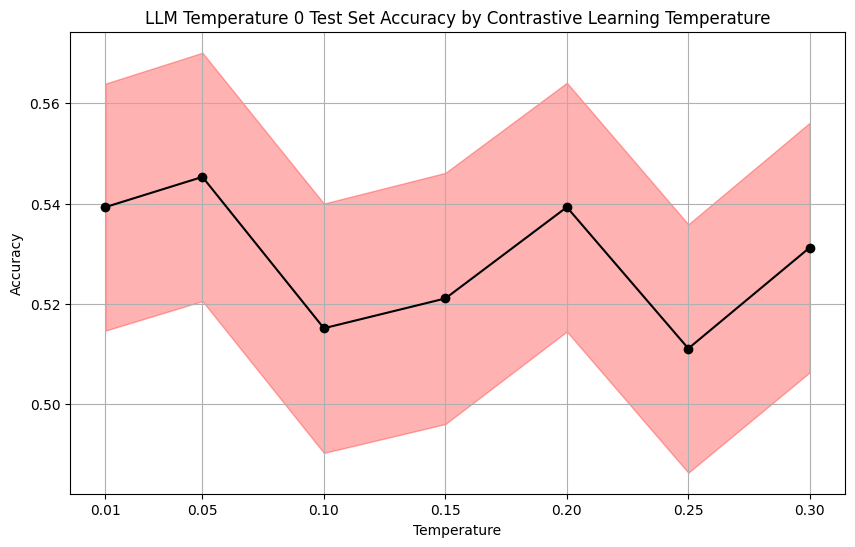

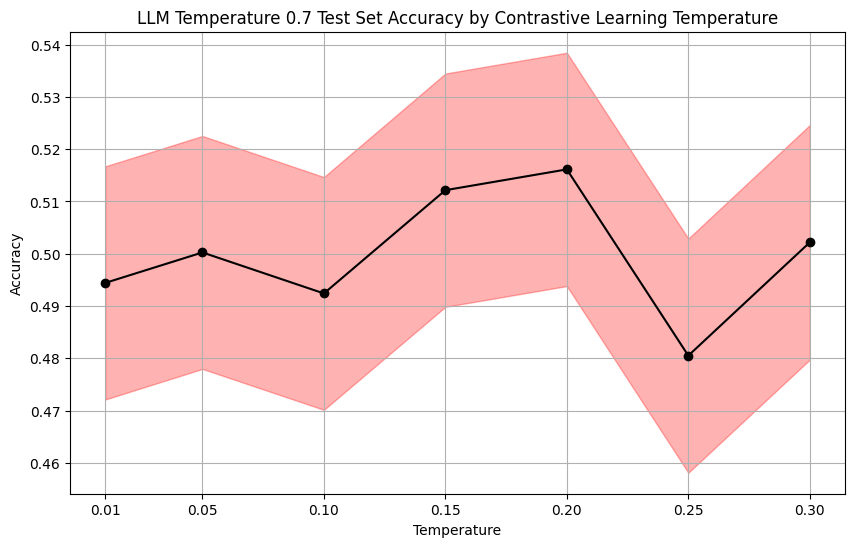

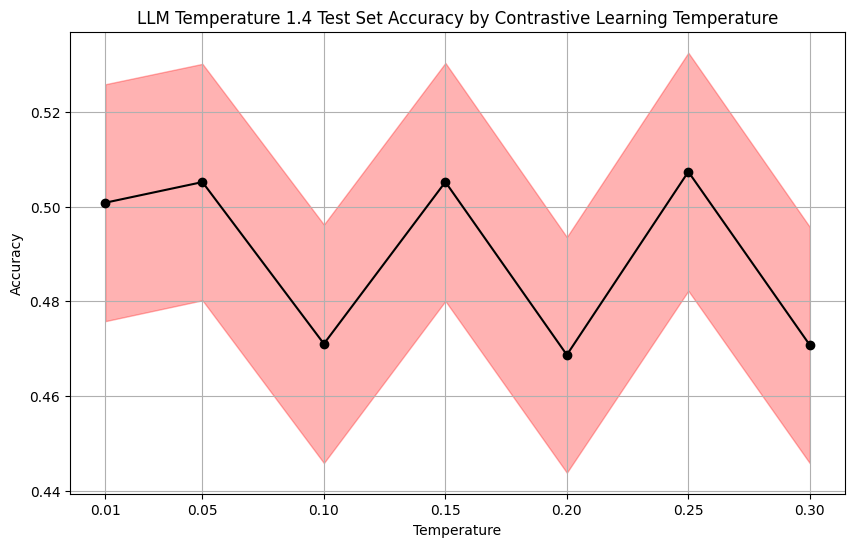

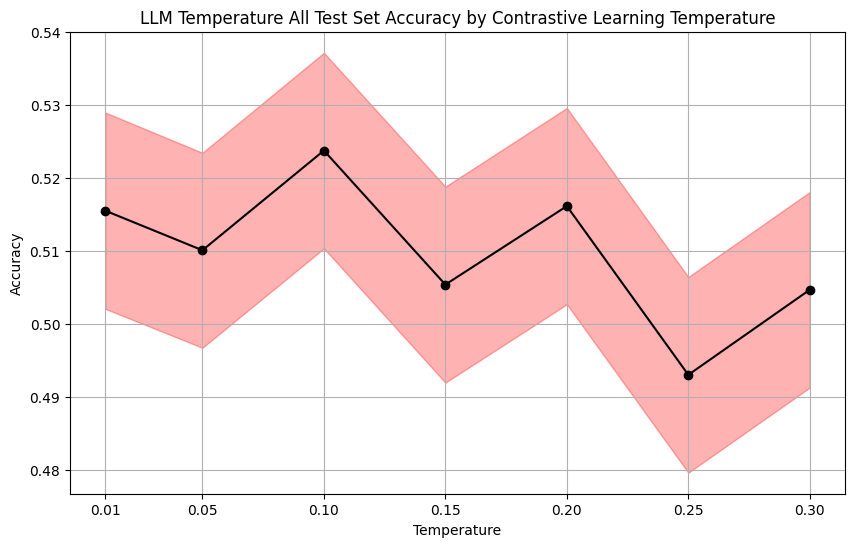

In [245]:
def gen_supcon_temp_plot(temp):
    plt.figure(figsize=(10, 6))
    plt.plot(supcon_temp_df.index, supcon_temp_df[f'temp_{temp}'], label=f'Temperature {temp}', color='black', marker='o')
    plt.fill_between(
        supcon_temp_df.index,
        supcon_temp_df[f'temp_{temp}'] - supcon_temp_df[f'temp_{temp}_stds'],  
        supcon_temp_df[f'temp_{temp}'] + supcon_temp_df[f'temp_{temp}_stds'],  
        color='red', alpha=0.3  
    )
    
    temp_dict = {'0':'0', '7':'0.7', '14':'1.4', 'all':'All'}
    plt.title(f'LLM Temperature {temp_dict[temp]} Test Set Accuracy by Contrastive Learning Temperature')
    plt.xlabel('Temperature')
    plt.ylabel('Accuracy')
    plt.xticks(supcon_temp_df.index) 
    plt.grid()
    plt.show()
for temp in ['0','7','14','all']:
    gen_supcon_temp_plot(temp)

## 1.3 Training Data Curves

In [246]:
def get_restricted_dataloaders(train_embs, test_embs, train_targs, test_targs, sample_size):
    total_length = len(train_embs)
    BATCH_SIZE = max(1,int(0.03*sample_size))
    train_indicies = [i for i in range(total_length)]
    selected_indices = np.random.choice(train_indicies, size = sample_size, replace = False)
    sampled_train_embs = [train_embs[idx] for idx in selected_indices]
    sampled_train_targs = [train_targs[idx] for idx in selected_indices]
    dataset_train = dlg.WordEmbeddingDataset(sampled_train_embs, sampled_train_targs)
    dataset_test = dlg.WordEmbeddingDataset(test_embs, test_targs)
    dataloader_train = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = True, drop_last=True)
    dataloader_test = DataLoader(dataset_test, batch_size = BATCH_SIZE, shuffle = True, drop_last=True)
    return dataloader_train, dataloader_test

In [ ]:
sample_sizes= []
temp_0_data_size_accs = []
temp_0_data_size_stds = []
temp_7_data_size_accs = []
temp_7_data_size_stds = []
temp_14_data_size_accs = []
temp_14_data_size_stds = []
temp_all_data_size_accs = []
temp_all_data_size_stds = []

sample_size = 10
stop_size = np.max([len(dlg.temp_0_train),len(dlg.temp_7_train), len(dlg.temp_14_train), len(dlg.temp_all_train)])
while sample_size <= stop_size:
    try:
        temp_0_model = SCL.Model(*get_restricted_dataloaders(dlg.temp_0_train, dlg.temp_0_val, 
                                                                     dlg.temp_0_targs_train, dlg.temp_0_targs_val, sample_size))
        temp_0_model.gen_model(900, 0.05)
        accs= temp_0_model.run_bootstrap(10000, dlg.temp_0_test, dlg.temp_0_targs_test)
        temp_0_data_size_accs.append(np.mean(accs))
        temp_0_data_size_stds.append(np.std(accs))
    except:
        pass
    try:
        temp_7_model = SCL.Model(*get_restricted_dataloaders(dlg.temp_7_train, dlg.temp_7_val, 
                                                                     dlg.temp_7_targs_train, dlg.temp_7_targs_val, sample_size))
        temp_7_model.gen_model(900, 0.20)
        accs= temp_7_model.run_bootstrap(10000, dlg.temp_7_test, dlg.temp_7_targs_test)
        temp_7_data_size_accs.append(np.mean(accs))
        temp_7_data_size_stds.append(np.std(accs))
    except:
        pass
    try:
        temp_14_model = SCL.Model(*get_restricted_dataloaders(dlg.temp_14_train, dlg.temp_14_val, 
                                                                      dlg.temp_14_targs_train, dlg.temp_14_targs_val, sample_size))
        temp_14_model.gen_model(200, 0.25)
        accs= temp_14_model.run_bootstrap(10000, dlg.temp_14_test, dlg.temp_14_targs_test)
        temp_14_data_size_accs.append(np.mean(accs))
        temp_14_data_size_stds.append(np.std(accs))
    except:
        pass
        
    try:
        temp_all_model = SCL.Model(*get_restricted_dataloaders(dlg.temp_all_train, dlg.temp_all_val, 
                                                                       dlg.temp_all_targs_train, dlg.temp_all_targs_val, sample_size))
        temp_all_model.gen_model(800, 0.1)
        accs= temp_all_model.run_bootstrap(10000, dlg.temp_all_test, dlg.temp_all_targs_test)
        temp_all_data_size_accs.append(np.mean(accs))
        temp_all_data_size_stds.append(np.std(accs))
    except:
        pass
    
    sample_sizes.append(sample_size) 
    sample_size *= 2
    

 10%|████████▎                                                                          | 1/10 [00:03<00:29,  3.29s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.25
Best Validation Accuracy: 0.2


 10%|████████▎                                                                          | 1/10 [00:04<00:37,  4.18s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.375
Best Validation Accuracy: 0.3


 10%|████████▎                                                                          | 1/10 [00:01<00:17,  1.89s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.375
Best Validation Accuracy: 0.4


 10%|████████▎                                                                          | 1/10 [00:03<00:33,  3.72s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5
Best Validation Accuracy: 0.3


 10%|████████▎                                                                          | 1/10 [00:07<01:10,  7.86s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.1875
Best Validation Accuracy: 0.15


 10%|████████▎                                                                          | 1/10 [00:07<01:10,  7.84s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.5
Best Validation Accuracy: 0.4


 10%|████████▎                                                                          | 1/10 [00:03<00:33,  3.72s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.25
Best Validation Accuracy: 0.25


 10%|████████▎                                                                          | 1/10 [00:07<01:08,  7.57s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.375
Best Validation Accuracy: 0.3


 10%|████████▎                                                                          | 1/10 [00:15<02:19, 15.47s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.21875
Best Validation Accuracy: 0.175


 10%|████████▎                                                                          | 1/10 [00:16<02:25, 16.15s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.375
Best Validation Accuracy: 0.375


 10%|████████▎                                                                          | 1/10 [00:07<01:05,  7.25s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.1875
Best Validation Accuracy: 0.275


 10%|████████▎                                                                          | 1/10 [00:17<02:33, 17.08s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.34375
Best Validation Accuracy: 0.3


 10%|████████▎                                                                          | 1/10 [00:19<02:51, 19.06s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.21875
Best Validation Accuracy: 0.2125


 10%|████████▎                                                                          | 1/10 [00:19<02:51, 19.11s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.3125
Best Validation Accuracy: 0.3


 10%|████████▎                                                                          | 1/10 [00:09<01:23,  9.24s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.28125
Best Validation Accuracy: 0.2875


 10%|████████▎                                                                          | 1/10 [00:13<02:05, 13.97s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.28125
Best Validation Accuracy: 0.275


 10%|████████▎                                                                          | 1/10 [00:15<02:18, 15.44s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.265625
Best Validation Accuracy: 0.225


 10%|████████▎                                                                          | 1/10 [00:16<02:24, 16.06s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.28125
Best Validation Accuracy: 0.30625


 10%|████████▎                                                                          | 1/10 [00:07<01:03,  7.01s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.28125
Best Validation Accuracy: 0.2875


 10%|████████▎                                                                          | 1/10 [00:14<02:07, 14.21s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.3203125
Best Validation Accuracy: 0.29375


 10%|████████▎                                                                          | 1/10 [00:14<02:10, 14.46s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.28125
Best Validation Accuracy: 0.271875


 10%|████████▎                                                                          | 1/10 [00:14<02:12, 14.78s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.3046875
Best Validation Accuracy: 0.30625


 10%|████████▎                                                                          | 1/10 [00:07<01:03,  7.05s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.26953125
Best Validation Accuracy: 0.275


 10%|████████▎                                                                          | 1/10 [00:13<02:01, 13.45s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.30859375
Best Validation Accuracy: 0.29375


 10%|████████▎                                                                          | 1/10 [00:16<02:28, 16.53s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.318359375
Best Validation Accuracy: 0.3015625


 10%|████████▎                                                                          | 1/10 [00:18<02:49, 18.80s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.36328125
Best Validation Accuracy: 0.3140625


 10%|████████▎                                                                          | 1/10 [00:08<01:13,  8.20s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.375
Best Validation Accuracy: 0.296875


 10%|████████▎                                                                          | 1/10 [00:15<02:20, 15.60s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.37890625
Best Validation Accuracy: 0.2921875


 10%|████████▎                                                                          | 1/10 [00:57<08:34, 57.17s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.525390625
Best Validation Accuracy: 0.51171875


 20%|████████████████▌                                                                  | 2/10 [02:20<09:39, 72.50s/it]

**MODEL UPDATED**
Average Training Accuracy: 0.546875
Best Validation Accuracy: 0.52265625


 40%|█████████████████████████████████▏                                                 | 4/10 [04:38<07:00, 70.04s/it]

In [262]:
# there are two iterations where models at 0, 0.7, and 1.4 will not have access to the data that the all temps model will have
temp_0_data_size_accs.extend([None, None])
temp_7_data_size_accs.extend([None, None])
temp_14_data_size_accs.extend([None, None])


In [264]:
data = {'temp_0':temp_0_data_size_accs, 'temp_7':temp_7_data_size_accs, 'temp_14':temp_14_data_size_accs, 'temp_all':temp_all_data_size_accs}
data_size_df = pd.DataFrame(data)
data_size_df.index = sample_sizes

ValueError: All arrays must be of the same length

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data_size_df.index, data_size_df['temp_0'], label='Temperature 0', color='red', marker='o')
plt.plot(data_size_df.index, data_size_df['temp_7'], label='Temperature 7', color='blue', marker='o')
plt.plot(data_size_df.index, data_size_df['temp_14'], label='Temperature 14', color='green', marker='o')
plt.plot(data_size_df.index, data_size_df['temp_all'], label='Temperature All', color='black', marker='o')

plt.xscale('log')
plt.title('Test Set Accuracy by Training Samples')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.xticks(data_size_df.index) 
plt.legend()
plt.grid()
plt.show()

## 1.4 Detailed Failure Analysis

In [208]:
response_df = dlg.response_df
# Load best models
temp_0_classifier = SCL.Classifier(900, 3, 0.3).eval()
temp_0_FAM = SCL.FAM(797, 900, 0.3).eval()
state_dict = torch.load('temp_0_models')
temp_0_FAM.load_state_dict(state_dict['fam_state_dict'])
temp_0_classifier.load_state_dict(state_dict['classifier_state_dict'])

temp_7_classifier = SCL.Classifier(900, 3, 0.3).eval()
temp_7_FAM = SCL.FAM(797, 900, 0.3).eval()
state_dict = torch.load('temp_7_models')
temp_7_FAM.load_state_dict(state_dict['fam_state_dict'])
temp_7_classifier.load_state_dict(state_dict['classifier_state_dict'])

temp_14_classifier = SCL.Classifier(200, 3, 0.3).eval()
temp_14_FAM = SCL.FAM(797, 200, 0.3).eval()
state_dict = torch.load('temp_14_models')
temp_14_FAM.load_state_dict(state_dict['fam_state_dict'])
temp_14_classifier.load_state_dict(state_dict['classifier_state_dict'])

temp_all_classifier = SCL.Classifier(800, 3, 0.3).eval()
temp_all_FAM = SCL.FAM(797, 800, 0.3).eval()
state_dict = torch.load('temp_all_models')
temp_all_FAM.load_state_dict(state_dict['fam_state_dict'])
temp_all_classifier.load_state_dict(state_dict['classifier_state_dict'])

<All keys matched successfully>

In [209]:
# Get confident wrong predictions from temp 0 model
temp_0_df_indices = [idx for idx in dlg.test_indices if response_df['temperature'][idx]==0.0]
temp_0_high_prob_idx = []
all_wrong_idx = []

temp_0_wrong_idx = []
temp_0_probs = []
temp_0_correct_binary = []
fam_embeddings = []
for i, embedding in enumerate(dlg.temp_0_test):
    fam_output = temp_0_FAM(embedding)
    fam_embeddings.append(fam_output)
    logits = temp_0_classifier(fam_output)
    probs = F.softmax(logits, dim=1)
    max_prob, _ = torch.max(probs, dim=1)
    pred = probs.argmax(1)
    target = dlg.temp_0_targs_test[i]
    df_idx = temp_0_df_indices[i]
    if pred != target:
        temp_0_correct_binary.append(0)
        if max_prob > 0.6:
            temp_0_high_prob_idx.append(df_idx)
        if df_idx not in all_wrong_idx:
            all_wrong_idx.append(df_idx)
        temp_0_wrong_idx.append(df_idx)
    else:
        temp_0_correct_binary.append(1)
    temp_0_probs.append(max_prob.item())
temp_0_correct_idx = [idx for idx in temp_0_df_indices if idx not in temp_0_wrong_idx]

In [210]:
# Get confident wrong predictions from temp 7 model
temp_7_df_indices = [idx for idx in dlg.test_indices if response_df['temperature'][idx]==0.7]
temp_7_high_prob_idx = []
all_wrong_idx = []
temp_7_wrong_idx = []
temp_7_probs = []
temp_7_correct_binary = []
for i, embedding in enumerate(dlg.temp_7_test):
    fam_output = temp_7_FAM(embedding)
    fam_embeddings.append(fam_output)
    logits = temp_7_classifier(fam_output)
    probs = F.softmax(logits, dim=1)
    max_prob, _ = torch.max(probs, dim=1)
    pred = probs.argmax(1)
    target = dlg.temp_7_targs_test[i]
    df_idx = temp_7_df_indices[i]
    if pred != target:
        temp_7_correct_binary.append(0)
        if max_prob > 0.6:
            temp_7_high_prob_idx.append(df_idx)
        if df_idx not in all_wrong_idx:
            all_wrong_idx.append(df_idx)
        temp_7_wrong_idx.append(df_idx)
    else:
        temp_7_correct_binary.append(1)
    temp_7_probs.append(max_prob.item())
temp_7_correct_idx = [idx for idx in temp_7_df_indices if idx not in temp_7_wrong_idx]

In [211]:
# Get confident wrong predictions from temp 14 model
temp_14_df_indices = [idx for idx in dlg.test_indices if response_df['temperature'][idx]==1.4]
temp_14_high_prob_idx = []
all_wrong_idx = []
temp_14_wrong_idx = []
temp_14_probs = []
temp_14_correct_binary = []
for i, embedding in enumerate(dlg.temp_14_test):
    fam_output = temp_14_FAM(embedding)
    fam_embeddings.append(fam_output)
    logits = temp_14_classifier(fam_output)
    probs = F.softmax(logits, dim=1)
    max_prob, _ = torch.max(probs, dim=1)
    pred = probs.argmax(1)
    target = dlg.temp_14_targs_test[i]
    df_idx = temp_14_df_indices[i]
    if pred != target:
        temp_14_correct_binary.append(0)
        if max_prob > 0.6:
            temp_14_high_prob_idx.append(df_idx)
        if df_idx not in all_wrong_idx:
            all_wrong_idx.append(df_idx)
        temp_14_wrong_idx.append(df_idx)
    else:
        temp_14_correct_binary.append(1)
    temp_14_probs.append(max_prob.item())
temp_14_correct_idx = [idx for idx in temp_14_df_indices if idx not in temp_14_wrong_idx]

In [212]:
# Get confident wrong predictions from temp all model
temp_all_df_indices = dlg.test_indices
temp_all_high_prob_idx = []
temp_all_wrong_idx = []
temp_all_probs = []
temp_all_correct_binary = []
for i, embedding in enumerate(dlg.temp_all_test):
    fam_output = temp_all_FAM(embedding)
    fam_embeddings.append(fam_output)
    logits = temp_all_classifier(fam_output)
    probs = F.softmax(logits, dim=1)
    max_prob, _ = torch.max(probs, dim=1)
    pred = probs.argmax(1)
    target = dlg.temp_all_targs_test[i]
    df_idx = temp_all_df_indices[i]
    if pred != target:
        temp_all_correct_binary.append(0)
        if max_prob > 0.6:
            temp_all_high_prob_idx.append(df_idx)
        if df_idx not in all_wrong_idx:
            all_wrong_idx.append(df_idx)
        temp_all_wrong_idx.append(df_idx)
    else:
        temp_all_correct_binary.append(1)
    temp_all_probs.append(max_prob.item())
temp_all_correct_idx = [idx for idx in temp_all_df_indices if idx not in temp_all_wrong_idx]

In [213]:
all_wrong_idx = temp_0_wrong_idx + temp_7_wrong_idx + temp_14_wrong_idx + temp_all_wrong_idx

In [171]:
all_high_prob = temp_0_high_prob_idx + temp_7_high_prob_idx + temp_14_high_prob_idx + temp_all_high_prob_idx
model_freqs_high_prob = {}
for idx in all_high_prob:
    row = response_df.iloc[idx]
    model = row['model']
    if model in model_freqs_high_prob:
        model_freqs_high_prob[model]+=1
    else:
        model_freqs_high_prob[model] = 1
    print('Model: ' + model)
    print(idx)
    print('Response: ')
    print(row['response_text'])
    print('---------------------------------------------')
    print('\n\n\n\n\n\n\n\n')

Model: gpt-4o-2024-05-13
9868
Response: 
Maksim Chmerkovskiy recently garnered attention for his absence from "Dancing with the Stars" earlier this season, amid speculation about tensions with his partner, Vanessa Lachey. This controversy has continued to captivate audiences, particularly on social media platforms like Twitter. Following their Snow White-themed performance on Disney Night, viewers of the ABC reality dance competition voiced their opinions on the pair's on-stage chemistry.

Observations from fans suggested an apparent strain between Chmerkovskiy and Lachey, with some commentators noting that the tension was palpable. However, contrary to these perceptions, behind-the-scenes interactions conveyed a different narrative. During a commercial break before their performance, both Chmerkovskiy and Lachey engaged warmly with Lachey’s two older children, who were present in the front row. This family interaction was followed by a cooperative rehearsal on the ballroom floor, pepp

In [172]:
model_freqs_high_prob

{'gpt-4o-2024-05-13': 49, 'mistral': 29, 'llama3.1-70b': 13}

In [191]:
model_freqs_all = {}
for idx in all_wrong_idx:
    row = response_df.iloc[idx]
    model = row['model']
    if model in model_freqs_all:
        model_freqs_all[model]+=1
    else:
        model_freqs_all[model] = 1
    print('Model: ' + model)
    print('Response: ')
    print('Index: ' + str(idx))
    print(row['response_text'])
    print('---------------------------------------------')
    print('\n\n\n\n\n\n\n\n')

Model: gpt-4o-2024-05-13
Response: 
Index: 9730
 Headline: Robert Pattinson Sparks Speculation About Relationship Status with FKA Twigs

Hollywood, CA - Renowned actor Robert Pattinson has recently become a topic of significant public interest, igniting conversations about his romantic life. The 31-year-old star, best known for his roles in the "Twilight" series and "The Lighthouse," made waves late last month following a revealing interview with Howard Stern.

During the candid conversation, Pattinson ambiguously described his engagement status with singer FKA twigs as "kind of," leaving fans and media outlets speculating about the true nature of their relationship. This vague remark has led to widespread curiosity and varying interpretations regarding whether the couple is on the verge of marriage or experiencing uncertainties in their engagement.

Pattinson and FKA twigs, whose real name is Tahliah Barnett, have been a high-profile couple since they first began dating in 2014. Their

In [176]:
model_freqs_all

{'gpt-4o-2024-05-13': 432, 'llama3.1-70b': 459, 'mistral': 569}

In [199]:
languages = {}
for _, row in response_df.iterrows():
    text = row['response_text']
    language = detect(text)
    if language in languages:
        languages[language] += 1
    else:
        languages[language] = 1

In [200]:
languages

{'en': 14602, 'es': 18, 'ru': 13, 'ja': 1, 'it': 1, 'da': 2}

In [201]:
35/len(response_df)

0.0023912003825920613

In [177]:
correct_idx = temp_0_correct_idx + temp_7_correct_idx + temp_14_correct_idx + temp_all_correct_idx
correct_lens = [len(response_df.iloc[idx]['response_text']) for idx in correct_idx]
incorrect_lens = [len(response_df.iloc[idx]['response_text']) for idx in all_wrong_idx]

In [180]:
df = dlg.response_df
num_model_0 = len(df[df['model_nums'] == 0])
num_model_1 = len(df[df['model_nums'] == 1])
num_model_2 = len(df[df['model_nums'] == 2])
total = len(df)
rand_expected_success = 100*((num_model_0/total)**2 + (num_model_1/total)**2 + (num_model_2/total)**2)
rand_expected_failure = 100 - rand_expected_success

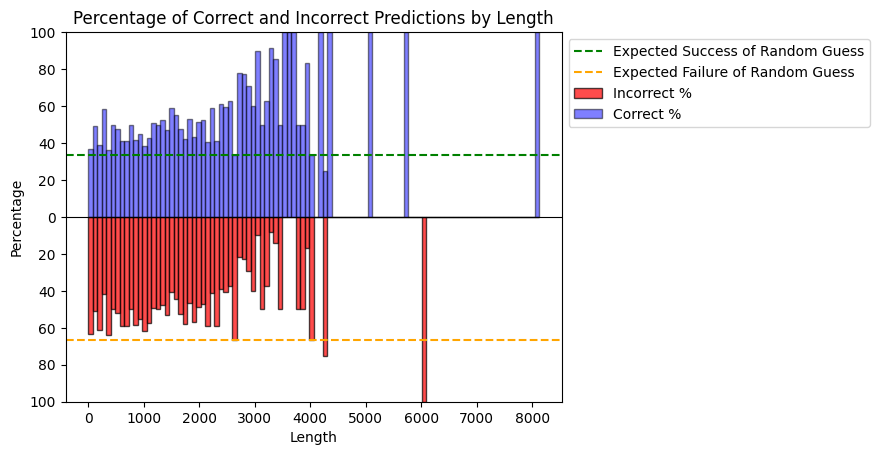

In [190]:
all_lens = correct_lens + incorrect_lens
bins = np.linspace(min(all_lens), max(all_lens), 101)  
correct_hist, _ = np.histogram(correct_lens, bins=bins)
incorrect_hist, _ = np.histogram(incorrect_lens, bins=bins)
total_hist = correct_hist + incorrect_hist
total_hist = np.where(total_hist == 0, 1, total_hist)

percent_incorrect = (incorrect_hist / total_hist) * 100
percent_correct = (correct_hist / total_hist) * 100
percent_incorrect = -percent_incorrect
plt.bar(bins[:-1], percent_incorrect, width=np.diff(bins), edgecolor='black', alpha=0.7, color='red', label='Incorrect %')

plt.bar(bins[:-1], percent_correct, width=np.diff(bins), edgecolor='black', alpha=0.5, color='blue', label='Correct %')

plt.title('Percentage of Correct and Incorrect Predictions by Length')
plt.xlabel('Length')
plt.ylabel('Percentage')

plt.axhline(rand_expected_success, color='green', linestyle='--', linewidth=1.5, label='Expected Success of Random Guess')
plt.axhline(-rand_expected_failure, color='orange', linestyle='--', linewidth=1.5, label='Expected Failure of Random Guess')
plt.axhline(0, color='black', linewidth=0.8)

plt.ylim(-100, 100)
plt.gca().set_yticks(np.arange(-100, 101, 20)) 

plt.gca().set_yticklabels([str(abs(int(i))) if i < 0 else str(int(i)) for i in np.arange(-100, 101, 20)])
plt.legend(bbox_to_anchor=(1, 1.))
plt.show()

In [196]:
len(response_df[response_df['response_text'].apply(lambda x: len(x)) < 200])/len(response_df)

0.06415249026439844

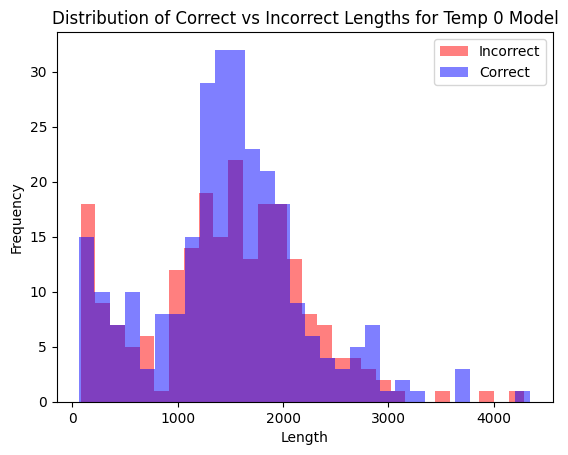

In [398]:
correct_lens_0 = [len(response_df.iloc[idx]['response_text']) for idx in temp_0_correct_idx]
incorrect_lens_0 = [len(response_df.iloc[idx]['response_text']) for idx in temp_0_wrong_idx]
plt.hist(incorrect_lens_0, bins=30, alpha=0.5, label='Incorrect', color='red')

# Plot the histogram for correct_lens
plt.hist(correct_lens_0, bins=30, alpha=0.5, label='Correct', color='blue')

# Add titles and labels
plt.title('Distribution of Correct vs Incorrect Lengths for Temp 0 Model')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()

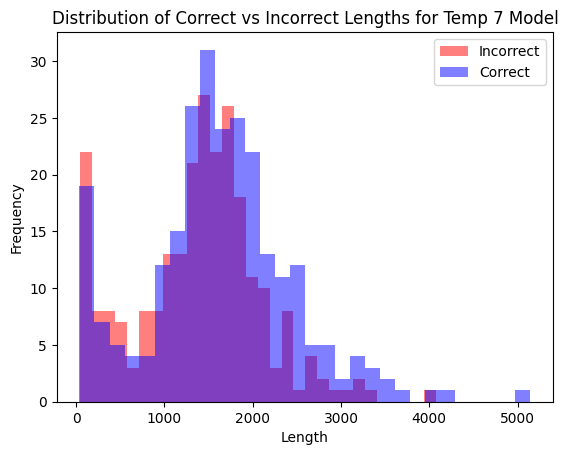

In [399]:
correct_lens_7 = [len(response_df.iloc[idx]['response_text']) for idx in temp_7_correct_idx]
incorrect_lens_7 = [len(response_df.iloc[idx]['response_text']) for idx in temp_7_wrong_idx]
plt.hist(incorrect_lens_7, bins=30, alpha=0.5, label='Incorrect', color='red')

# Plot the histogram for correct_lens
plt.hist(correct_lens_7, bins=30, alpha=0.5, label='Correct', color='blue')

# Add titles and labels
plt.title('Distribution of Correct vs Incorrect Lengths for Temp 7 Model')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()

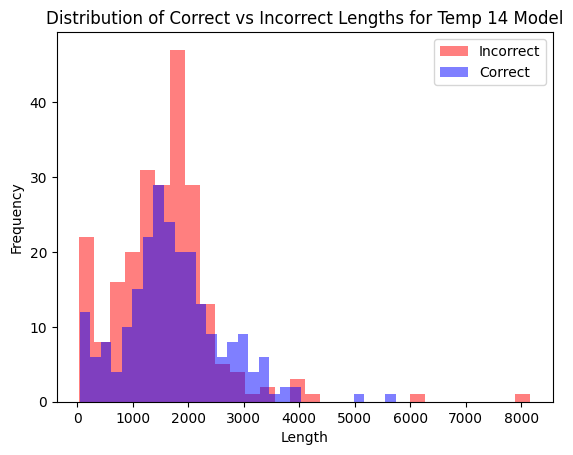

In [400]:
correct_lens_14 = [len(response_df.iloc[idx]['response_text']) for idx in temp_14_correct_idx]
incorrect_lens_14 = [len(response_df.iloc[idx]['response_text']) for idx in temp_14_wrong_idx]
plt.hist(incorrect_lens_14, bins=30, alpha=0.5, label='Incorrect', color='red')

# Plot the histogram for correct_lens
plt.hist(correct_lens_14, bins=30, alpha=0.5, label='Correct', color='blue')

# Add titles and labels
plt.title('Distribution of Correct vs Incorrect Lengths for Temp 14 Model')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()

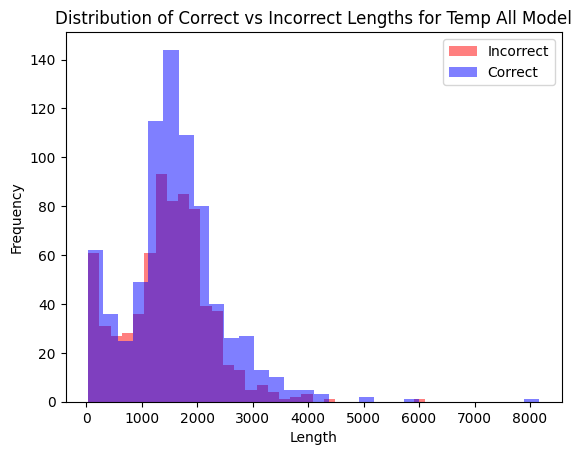

In [401]:
correct_lens_all = [len(response_df.iloc[idx]['response_text']) for idx in temp_all_correct_idx]
incorrect_lens_all = [len(response_df.iloc[idx]['response_text']) for idx in temp_all_wrong_idx]
plt.hist(incorrect_lens_all, bins=30, alpha=0.5, label='Incorrect', color='red')

# Plot the histogram for correct_lens
plt.hist(correct_lens_all, bins=30, alpha=0.5, label='Correct', color='blue')

# Add titles and labels
plt.title('Distribution of Correct vs Incorrect Lengths for Temp All Model')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [203]:
embeddings = dlg.embeddings
correct_embs = [temp_0_FAM(embeddings[idx]) for idx in temp_0_correct_idx]
wrong_embs = [temp_0_FAM(embeddings[idx]) for idx in temp_0_wrong_idx]
correct_embs_stacked = torch.stack(correct_embs).detach().squeeze(1).numpy()
incorrect_embs_stacked = torch.stack(wrong_embs).detach().squeeze(1).numpy()
cos_sim_correct = cosine_similarity(correct_embs_stacked)
cos_sim_incorrect = cosine_similarity(incorrect_embs_stacked)
cos_sim_cross = cosine_similarity(correct_embs_stacked, incorrect_embs_stacked)

print("Cosine similarity within correct vectors:", np.mean(cos_sim_correct))
print("Cosine similarity within incorrect vectors:", np.mean(cos_sim_incorrect))
print("Cosine similarity between correct and incorrect vectors:", np.mean(cos_sim_cross))

Cosine similarity within correct vectors: 0.47612345
Cosine similarity within incorrect vectors: 0.4880618
Cosine similarity between correct and incorrect vectors: 0.47964457


In [204]:
embeddings = dlg.embeddings
correct_embs = [temp_7_FAM(embeddings[idx]) for idx in temp_7_correct_idx]
wrong_embs = [temp_7_FAM(embeddings[idx]) for idx in temp_7_wrong_idx]
correct_embs_stacked = torch.stack(correct_embs).detach().squeeze(1).numpy()
incorrect_embs_stacked = torch.stack(wrong_embs).detach().squeeze(1).numpy()
cos_sim_correct = cosine_similarity(correct_embs_stacked)
cos_sim_incorrect = cosine_similarity(incorrect_embs_stacked)
cos_sim_cross = cosine_similarity(correct_embs_stacked, incorrect_embs_stacked)

print("Cosine similarity within correct vectors:", np.mean(cos_sim_correct))
print("Cosine similarity within incorrect vectors:", np.mean(cos_sim_incorrect))
print("Cosine similarity between correct and incorrect vectors:", np.mean(cos_sim_cross))

Cosine similarity within correct vectors: 0.68312836
Cosine similarity within incorrect vectors: 0.7223972
Cosine similarity between correct and incorrect vectors: 0.7000596


In [205]:
embeddings = dlg.embeddings
correct_embs = [temp_14_FAM(embeddings[idx]) for idx in temp_14_correct_idx]
wrong_embs = [temp_14_FAM(embeddings[idx]) for idx in temp_14_wrong_idx]
correct_embs_stacked = torch.stack(correct_embs).detach().squeeze(1).numpy()
incorrect_embs_stacked = torch.stack(wrong_embs).detach().squeeze(1).numpy()
cos_sim_correct = cosine_similarity(correct_embs_stacked)
cos_sim_incorrect = cosine_similarity(incorrect_embs_stacked)
cos_sim_cross = cosine_similarity(correct_embs_stacked, incorrect_embs_stacked)

print("Cosine similarity within correct vectors:", np.mean(cos_sim_correct))
print("Cosine similarity within incorrect vectors:", np.mean(cos_sim_incorrect))
print("Cosine similarity between correct and incorrect vectors:", np.mean(cos_sim_cross))

Cosine similarity within correct vectors: 0.52928567
Cosine similarity within incorrect vectors: 0.695833
Cosine similarity between correct and incorrect vectors: 0.59958094


In [206]:
embeddings = dlg.embeddings
correct_embs = [temp_all_FAM(embeddings[idx]) for idx in temp_all_correct_idx]
wrong_embs = [temp_all_FAM(embeddings[idx]) for idx in temp_all_wrong_idx]
correct_embs_stacked = torch.stack(correct_embs).detach().squeeze(1).numpy()
incorrect_embs_stacked = torch.stack(wrong_embs).detach().squeeze(1).numpy()
cos_sim_correct = cosine_similarity(correct_embs_stacked)
cos_sim_incorrect = cosine_similarity(incorrect_embs_stacked)
cos_sim_cross = cosine_similarity(correct_embs_stacked, incorrect_embs_stacked)

print("Cosine similarity within correct vectors:", np.mean(cos_sim_correct))
print("Cosine similarity within incorrect vectors:", np.mean(cos_sim_incorrect))
print("Cosine similarity between correct and incorrect vectors:", np.mean(cos_sim_cross))

Cosine similarity within correct vectors: 0.6531452
Cosine similarity within incorrect vectors: 0.7101567
Cosine similarity between correct and incorrect vectors: 0.6804024


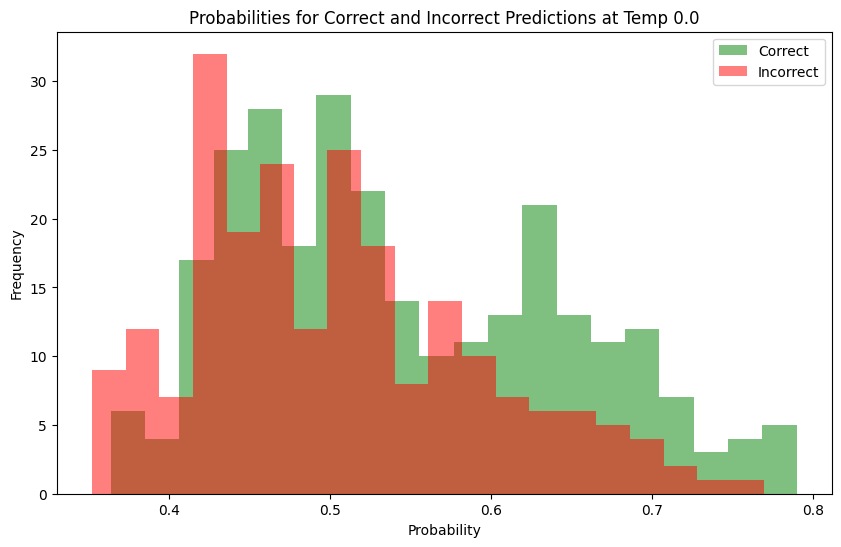

In [449]:
correct_probs = [prob for prob, correct in zip(temp_0_probs, temp_0_correct_binary) if correct == 1]
incorrect_probs = [prob for prob, correct in zip(temp_0_probs, temp_0_correct_binary) if correct == 0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(correct_probs, bins=20, alpha=0.5, label='Correct', color='g')
plt.hist(incorrect_probs, bins=20, alpha=0.5, label='Incorrect', color='r')

# Add title and labels
plt.title('Probabilities for Correct and Incorrect Predictions at Temp 0.0')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Add legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

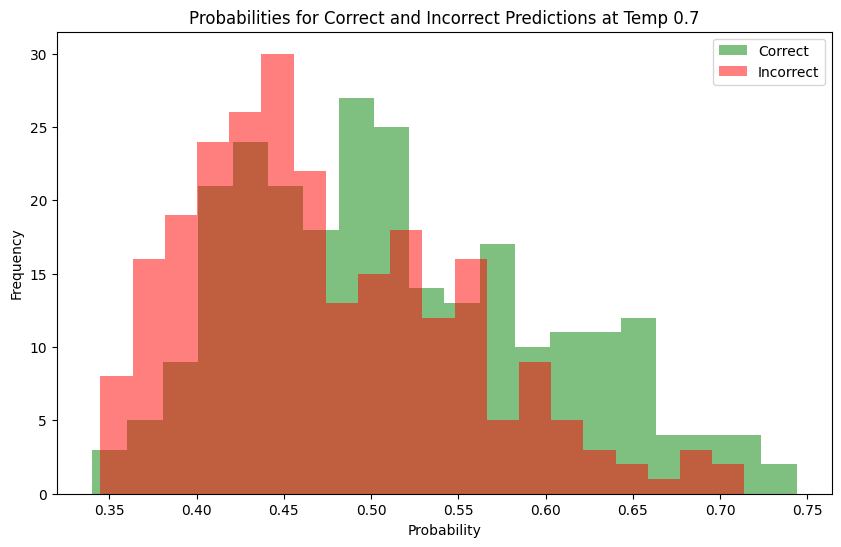

In [450]:
correct_probs = [prob for prob, correct in zip(temp_7_probs, temp_7_correct_binary) if correct == 1]
incorrect_probs = [prob for prob, correct in zip(temp_7_probs, temp_7_correct_binary) if correct == 0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(correct_probs, bins=20, alpha=0.5, label='Correct', color='g')
plt.hist(incorrect_probs, bins=20, alpha=0.5, label='Incorrect', color='r')

# Add title and labels
plt.title('Probabilities for Correct and Incorrect Predictions at Temp 0.7')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Add legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

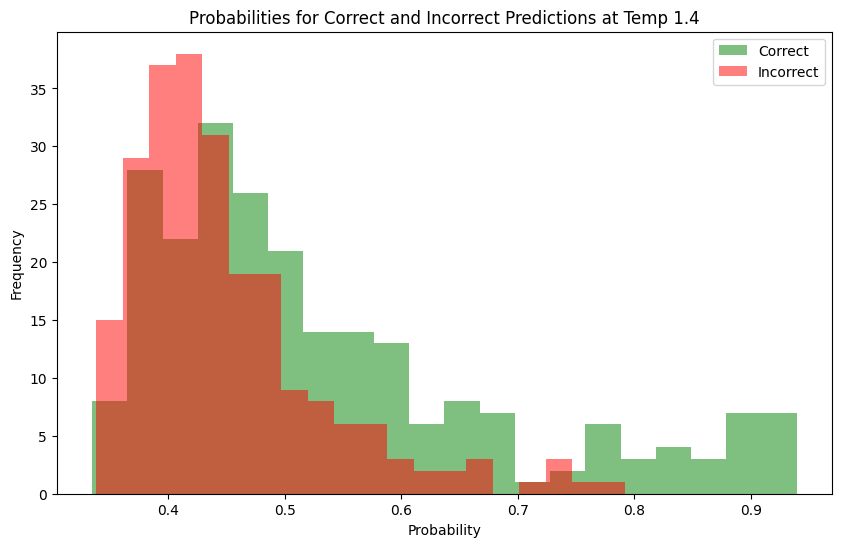

In [451]:
correct_probs = [prob for prob, correct in zip(temp_14_probs, temp_14_correct_binary) if correct == 1]
incorrect_probs = [prob for prob, correct in zip(temp_14_probs, temp_14_correct_binary) if correct == 0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(correct_probs, bins=20, alpha=0.5, label='Correct', color='g')
plt.hist(incorrect_probs, bins=20, alpha=0.5, label='Incorrect', color='r')

# Add title and labels
plt.title('Probabilities for Correct and Incorrect Predictions at Temp 1.4')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Add legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

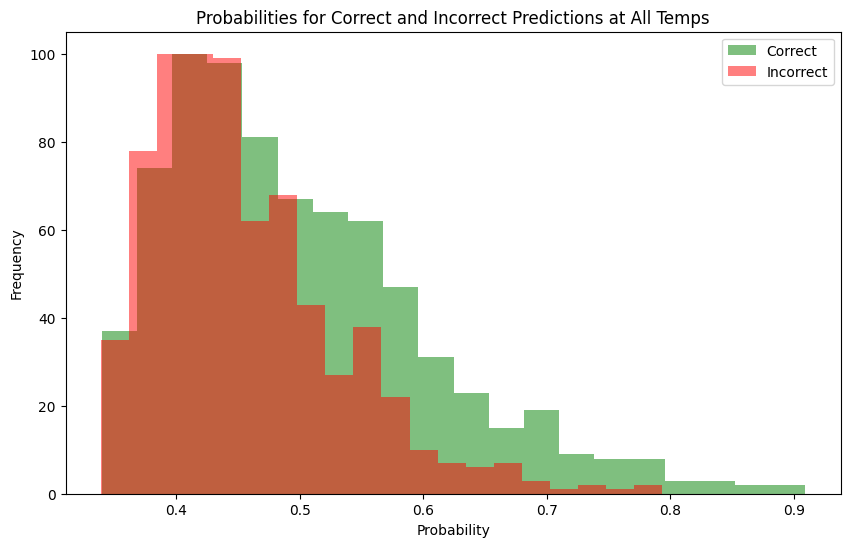

In [452]:
correct_probs = [prob for prob, correct in zip(temp_all_probs, temp_all_correct_binary) if correct == 1]
incorrect_probs = [prob for prob, correct in zip(temp_all_probs, temp_all_correct_binary) if correct == 0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(correct_probs, bins=20, alpha=0.5, label='Correct', color='g')
plt.hist(incorrect_probs, bins=20, alpha=0.5, label='Incorrect', color='r')

# Add title and labels
plt.title('Probabilities for Correct and Incorrect Predictions at All Temps')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Add legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [ ]:
# declare feature names for regression
stylometric_features_list = ['Average Word Length', 'Stopword Ratio', 'MTTR', "ADJ", "ADP", 
                        "ADV", "AUX", "CONJ", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", 
                "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X", "SPACE", 'Average Words Per Sentence', 'Active Voice', 
                        'Present Tense', 'Sentences Per Paragraph', 'Words Per Paragraph', 'Punctuation Per Word', 'Capitals Per Word']

In [225]:
# logistic regression on accuracy using stylometric embeddings
all_indices = temp_0_df_indices + temp_7_df_indices + temp_14_df_indices + temp_all_df_indices
embs = [dlg.embeddings[idx] for idx in all_indices]
flattened_embeddings = [embedding.flatten().detach().numpy() for embedding in embs]



stylometric_regression_df = pd.DataFrame(flattened_embeddings)
stylometric_regression_df['correct'] = classifications
stylometric_regression_df.drop([i for i in range(0,796-29)], axis = 1, inplace=True)


In [226]:
stylometric_regression_df

,767,768,769,770,771,772,773,774,775,776,...,788,789,790,791,792,793,794,795,796,correct
0,0.192452,0.055761,0.003810,0.009813,0.166814,0.304190,0.147189,0.098126,0.0,0.088313,...,0.0,0.058876,0.260579,0.009813,0.0,0.014719,0.390868,0.001396,0.001478,0
1,0.411137,0.061867,0.004946,0.011492,0.195365,0.321777,0.091936,0.172381,0.0,0.080444,...,0.0,0.057460,0.244780,0.000000,0.0,0.019153,0.407967,0.001295,0.001834,0
2,0.115655,0.053758,0.003010,0.009489,0.180295,0.189785,0.056935,0.104382,0.0,0.066425,...,0.0,0.037957,0.185831,0.000000,0.0,0.022774,0.445994,0.001333,0.001292,1
3,-0.006524,0.062452,0.003887,0.010565,0.274683,0.264118,0.095082,0.084518,0.0,0.063388,...,0.0,0.031694,0.245336,0.000000,0.0,0.023771,0.552006,0.001112,0.001820,1
4,0.534888,0.028869,0.001813,0.005766,0.098027,0.103794,0.034598,0.034598,0.0,0.040364,...,0.0,0.000000,0.179909,0.000000,0.0,0.028832,0.899546,0.001405,0.001848,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,0.746916,0.061482,0.005112,0.011706,0.163880,0.327759,0.140468,0.140468,0.0,0.105351,...,0.0,0.058528,0.257525,0.011706,0.0,0.019509,0.429208,0.001330,0.001969,0
2924,-0.167092,0.022467,0.001556,0.004372,0.083075,0.284202,0.122426,0.083075,0.0,0.096192,...,0.0,0.017489,0.047823,0.000000,0.0,0.041974,0.459096,0.000775,0.001066,0
2925,0.239843,0.021884,0.001432,0.003978,0.147178,0.278445,0.079556,0.107400,0.0,0.047733,...,0.0,0.091489,0.088705,0.000000,0.0,0.007956,0.177409,0.000612,0.000773,0
2926,-0.059712,0.055189,0.004208,0.010754,0.225828,0.311857,0.086030,0.150552,0.0,0.064522,...,0.0,0.053769,0.339510,0.000000,0.0,0.012546,0.396095,0.001557,0.002238,0


In [227]:
X = stylometric_regression_df.drop(columns='correct')
y = stylometric_regression_df['correct']  
model = LogisticRegression(max_iter=1000)

model.fit(X, y)

coefficients = model.coef_

In [230]:
print('Max Coefficient: ' + str(max(coefficients[0])))
print('Min Coefficient: ' + str(min(coefficients[0])))

Max Coefficient: 1.7642333521886258
Min Coefficient: -1.6159487444004421


In [237]:
np.argsort(coefficients)

array([[17, 27,  1, 10,  7, 13, 26, 20, 19, 11,  3,  2, 23,  9, 28,  8,
         0, 16, 25, 21, 18,  4, 12, 29, 24, 14,  5, 15, 22,  6]],
      dtype=int64)

In [238]:
highest = [stylometric_features_list[idx] for idx in np.argsort(coefficients)[0][:3]]
lowest = [stylometric_features_list[idx] for idx in np.argsort(coefficients)[0][-3:]]
print(highest)
print(lowest)

['SCONJ', 'Punctuation Per Word', 'Stopword Ratio']
['PROPN', 'Average Words Per Sentence', 'AUX']
